In [1]:
import pandas as pd
import unicodedata
import re
import jellyfish as jf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns



In [2]:
pd.set_option('display.max_columns', None)


# 1. Dataset

In [3]:
df = pd.read_csv("creditscoring_data.csv")

In [4]:
df.head(10)

,ID_CLIENT,ID_SHOP,SEX,MARITAL_STATUS,AGE,FLAG_RESIDENCIAL_PHONE,AREA_CODE_RESIDENCIAL_PHONE,PAYMENT_DAY,SHOP_RANK,RESIDENCE_TYPE,MONTHS_IN_RESIDENCE,FLAG_MOTHERS_NAME,FLAG_FATHERS_NAME,FLAG_RESIDENCE_TOWN_eq_WORKING_TOWN,FLAG_RESIDENCE_STATE_eq_WORKING_STATE,MONTHS_IN_THE_JOB,PROFESSION_CODE,MATE_INCOME,FLAG_RESIDENCIAL_ADDRESS_eq_POSTAL_ADDRESS,FLAG_OTHER_CARD,QUANT_BANKING_ACCOUNTS,FLAG_MOBILE_PHONE,FLAG_CONTACT_PHONE,PERSONAL_NET_INCOME,COD_APPLICATION_BOOTH,QUANT_ADDITIONAL_CARDS_IN_THE_APPLICATION,FLAG_CARD_INSURANCE_OPTION,TARGET_LABEL_BAD=1,Unnamed: 28
0,1,22,F,O,44,N,31,12,0,P,12,Y,Y,N,Y,48,731,0.0,Y,N,0,N,N,300,0,0,N,0,NaN
1,2,15,F,S,18,Y,31,20,0,P,216,Y,Y,Y,Y,12,853,0.0,Y,N,0,N,N,300,0,0,N,0,NaN
2,3,24,F,C,22,Y,31,8,0,P,48,Y,N,Y,Y,12,40,0.0,Y,N,0,N,N,229,0,0,N,0,NaN
3,4,12,F,C,47,N,31,25,0,P,180,Y,Y,N,Y,24,35,0.0,Y,N,0,N,N,304,0,0,N,0,NaN
4,5,16,F,S,28,Y,31,25,0,O,12,Y,Y,Y,Y,12,24,0.0,Y,N,0,N,N,250,0,0,N,0,NaN
5,6,24,M,S,26,N,31,28,0,P,180,Y,Y,N,Y,0,999,0.0,Y,N,0,N,N,800,0,0,N,0,NaN
6,7,55,F,S,22,Y,31,12,0,A,0,Y,Y,Y,Y,48,999,0.0,Y,N,0,N,N,410,0,0,N,0,NaN
7,8,6,F,C,21,Y,23,28,0,A,24,Y,Y,Y,Y,12,40,800.0,Y,N,0,N,N,248,0,0,N,0,NaN
8,9,3,F,S,27,Y,31,20,0,A,0,Y,Y,Y,Y,0,950,0.0,Y,N,0,N,N,1000,0,0,N,1,NaN
9,10,23,F,C,57,Y,31,12,0,P,24,Y,Y,N,Y,96,13,0.0,Y,N,0,N,N,856,0,0,N,0,NaN


In [5]:
df.dtypes

ID_CLIENT                                       int64
ID_SHOP                                         int64
SEX                                            object
MARITAL_STATUS                                 object
AGE                                             int64
FLAG_RESIDENCIAL_PHONE                         object
AREA_CODE_RESIDENCIAL_PHONE                     int64
PAYMENT_DAY                                     int64
SHOP_RANK                                       int64
RESIDENCE_TYPE                                 object
MONTHS_IN_RESIDENCE                             int64
FLAG_MOTHERS_NAME                              object
FLAG_FATHERS_NAME                              object
FLAG_RESIDENCE_TOWN_eq_WORKING_TOWN            object
FLAG_RESIDENCE_STATE_eq_WORKING_STATE          object
MONTHS_IN_THE_JOB                               int64
PROFESSION_CODE                                 int64
MATE_INCOME                                   float64
FLAG_RESIDENCIAL_ADDRESS_eq_

In [6]:
df.shape

(40000, 29)

In [7]:
tot_registos, tot_variables = df.shape

# 2. Calidad de datos

## 2.1 Etiquetado de variables 

In [8]:
df.columns = df.columns.str.lower()
df.columns

Index(['id_client', 'id_shop', 'sex', 'marital_status', 'age',
       'flag_residencial_phone', 'area_code_residencial_phone', 'payment_day',
       'shop_rank', 'residence_type', 'months_in_residence',
       'flag_mothers_name', 'flag_fathers_name',
       'flag_residence_town_eq_working_town',
       'flag_residence_state_eq_working_state', 'months_in_the_job',
       'profession_code', 'mate_income',
       'flag_residencial_address_eq_postal_address', 'flag_other_card',
       'quant_banking_accounts', 'flag_mobile_phone', 'flag_contact_phone',
       'personal_net_income', 'cod_application_booth',
       'quant_additional_cards_in_the_application',
       'flag_card_insurance_option', 'target_label_bad=1', 'unnamed: 28'],
      dtype='object')

In [9]:
v_feats=["sex","marital_status",'flag_residencial_phone', 'area_code_residencial_phone', 'residence_type',
         'flag_mothers_name',"flag_fathers_name","flag_residence_town_eq_working_town","flag_residence_state_eq_working_state",
         "mes_inicio","agencia","calle_hechos","calle_hechos2","profession_code","flag_residencial_address_eq_postal_address",
         "flag_other_card","flag_mobile_phone","flag_contact_phone","cod_application_booth","quant_additional_cards_in_the_application",
        "target_label_bad=1"]
c_feats=['age','payment_day',"shop_rank","months_in_residence","months_in_the_job","mate_income","quant_banking_accounts",
        "personal_net_income","quant_additional_cards_in_the_application"]

c_feats_new=["c_"+x for x in c_feats]
v_feats_new=["v_"+x for x in v_feats]

df.rename(columns=dict(zip(c_feats,c_feats_new)),inplace=True)
df.rename(columns=dict(zip(v_feats,v_feats_new)),inplace=True)


eliminamos la ultima columna ya que no trae datos

In [10]:
df = df.drop('unnamed: 28',axis = 1)

In [11]:
df

,id_client,id_shop,v_sex,v_marital_status,c_age,v_flag_residencial_phone,v_area_code_residencial_phone,c_payment_day,c_shop_rank,v_residence_type,c_months_in_residence,v_flag_mothers_name,v_flag_fathers_name,v_flag_residence_town_eq_working_town,v_flag_residence_state_eq_working_state,c_months_in_the_job,v_profession_code,c_mate_income,v_flag_residencial_address_eq_postal_address,v_flag_other_card,c_quant_banking_accounts,v_flag_mobile_phone,v_flag_contact_phone,c_personal_net_income,v_cod_application_booth,c_quant_additional_cards_in_the_application,flag_card_insurance_option,v_target_label_bad=1
0,1,22,F,O,44,N,31,12,0,P,12,Y,Y,N,Y,48,731,0.0,Y,N,0,N,N,300,0,0,N,0
1,2,15,F,S,18,Y,31,20,0,P,216,Y,Y,Y,Y,12,853,0.0,Y,N,0,N,N,300,0,0,N,0
2,3,24,F,C,22,Y,31,8,0,P,48,Y,N,Y,Y,12,40,0.0,Y,N,0,N,N,229,0,0,N,0
3,4,12,F,C,47,N,31,25,0,P,180,Y,Y,N,Y,24,35,0.0,Y,N,0,N,N,304,0,0,N,0
4,5,16,F,S,28,Y,31,25,0,O,12,Y,Y,Y,Y,12,24,0.0,Y,N,0,N,N,250,0,0,N,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,39996,23,F,S,30,Y,31,20,0,P,12,Y,Y,N,Y,48,1,0.0,Y,N,0,N,N,727,0,0,N,0
39996,39997,25,F,S,58,Y,31,12,0,P,48,Y,Y,N,Y,120,13,0.0,Y,N,0,N,N,1176,0,0,N,0
39997,39998,23,F,C,33,Y,31,1,0,P,36,Y,Y,Y,Y,36,717,0.0,Y,N,0,N,N,3500,0,1,N,0
39998,39999,15,F,C,36,Y,31,12,0,P,204,Y,Y,Y,Y,24,113,0.0,Y,N,0,N,N,1810,0,0,N,0


## 2.2 duplicidad


In [12]:
dup = df[df['id_client'].duplicated(keep = False)].sort_values(by = 'id_client')
dup

,id_client,id_shop,v_sex,v_marital_status,c_age,v_flag_residencial_phone,v_area_code_residencial_phone,c_payment_day,c_shop_rank,v_residence_type,c_months_in_residence,v_flag_mothers_name,v_flag_fathers_name,v_flag_residence_town_eq_working_town,v_flag_residence_state_eq_working_state,c_months_in_the_job,v_profession_code,c_mate_income,v_flag_residencial_address_eq_postal_address,v_flag_other_card,c_quant_banking_accounts,v_flag_mobile_phone,v_flag_contact_phone,c_personal_net_income,v_cod_application_booth,c_quant_additional_cards_in_the_application,flag_card_insurance_option,v_target_label_bad=1
11,12,12,F,C,32,Y,31,12,0,P,24,Y,Y,N,Y,0,165,0.0,Y,N,0,N,N,700,0,0,N,0
39,12,23,F,O,30,Y,31,12,0,O,240,Y,Y,N,Y,60,43,0.0,Y,N,0,N,N,300,0,0,N,1
33,34,3,F,S,40,Y,31,28,0,P,24,Y,Y,Y,Y,0,305,0.0,Y,N,0,N,N,1000,0,0,N,0
255,34,19,F,V,52,Y,31,8,0,P,204,Y,Y,N,Y,0,168,0.0,Y,N,0,N,N,387,0,0,N,0
66,67,1,F,O,38,N,50,12,0,P,144,Y,N,Y,Y,108,205,0.0,Y,N,0,N,N,180,0,0,N,0
376,67,15,F,C,20,Y,31,18,0,P,168,Y,Y,Y,Y,120,918,0.0,N,N,0,N,N,411,0,0,N,0
638,89,22,F,S,27,Y,31,12,0,P,360,Y,Y,N,Y,72,100,0.0,Y,N,0,N,N,1200,0,0,N,0
502,89,3,F,V,59,Y,23,12,0,P,156,Y,Y,N,Y,180,131,0.0,Y,N,0,N,N,800,0,0,N,0
88,89,25,F,C,41,Y,31,18,0,A,12,Y,Y,N,Y,240,501,0.0,Y,N,0,N,N,200,0,0,N,0
92,90,24,F,S,19,Y,50,12,0,C,36,Y,N,Y,Y,12,61,0.0,Y,N,0,N,N,200,0,0,N,1


veamos si hay Na, si los hay priorisamos por los registros con menos Na

In [13]:
dup.isna().sum(axis=1)

11       0
39       0
33       0
255      0
66       0
376      0
638      0
502      0
88       0
92       0
89       0
677      0
821      0
1344     0
176      0
39775    0
39818    0
39927    0
39854    0
39926    0
39994    0
dtype: int64

como no la hay proiorizamos por la edad del aplicante, priorizando la mayor edad ya que los aplicantes pudieron registrar sus datos en diferentes años y solo nos queremos quedar con los datos más actuales 

In [14]:
edades_maximas = dup.groupby('id_client')['c_age'].max().reset_index()

res = pd.merge(edades_maximas, dup.reset_index(),on=['id_client', 'c_age'], how='inner')
res

,id_client,c_age,index,id_shop,v_sex,v_marital_status,v_flag_residencial_phone,v_area_code_residencial_phone,c_payment_day,c_shop_rank,v_residence_type,c_months_in_residence,v_flag_mothers_name,v_flag_fathers_name,v_flag_residence_town_eq_working_town,v_flag_residence_state_eq_working_state,c_months_in_the_job,v_profession_code,c_mate_income,v_flag_residencial_address_eq_postal_address,v_flag_other_card,c_quant_banking_accounts,v_flag_mobile_phone,v_flag_contact_phone,c_personal_net_income,v_cod_application_booth,c_quant_additional_cards_in_the_application,flag_card_insurance_option,v_target_label_bad=1
0,12,32,11,12,F,C,Y,31,12,0,P,24,Y,Y,N,Y,0,165,0.0,Y,N,0,N,N,700,0,0,N,0
1,34,52,255,19,F,V,Y,31,8,0,P,204,Y,Y,N,Y,0,168,0.0,Y,N,0,N,N,387,0,0,N,0
2,67,38,66,1,F,O,N,50,12,0,P,144,Y,N,Y,Y,108,205,0.0,Y,N,0,N,N,180,0,0,N,0
3,89,59,502,3,F,V,Y,23,12,0,P,156,Y,Y,N,Y,180,131,0.0,Y,N,0,N,N,800,0,0,N,0
4,90,20,89,16,F,S,Y,31,28,0,A,24,Y,Y,N,Y,0,950,0.0,Y,N,0,N,N,350,0,0,N,0
5,678,35,821,16,F,S,Y,31,23,0,P,144,Y,Y,N,Y,12,131,0.0,Y,N,0,N,N,450,0,0,N,0
6,1345,35,176,22,F,O,Y,31,28,0,P,120,Y,Y,N,Y,216,950,0.0,Y,N,0,N,N,2500,0,0,N,0
7,39819,43,39775,14,F,C,N,50,25,0,O,144,Y,Y,Y,Y,120,717,0.0,Y,N,0,N,N,600,0,0,N,0
8,39819,43,39818,3,M,D,Y,31,18,0,P,528,Y,Y,Y,Y,120,717,0.0,Y,N,0,N,N,1200,0,0,N,1
9,39995,53,39926,1,F,C,Y,31,8,0,P,144,Y,Y,N,Y,36,13,0.0,Y,N,0,N,N,1190,0,1,N,0


esta tabla muestra los datos que conservariamos, el cliente 39829 sigue sin desduplicarse, vemos que ambos registros tienen edad de 43, ademas el sexo es diferente en ambos registros, esto es una inconsitencia y no hay forma de saber cual es el correcto, al ser solo un cliente con este caso se puede eliminar sin que imploque un impacto mayor

In [15]:
res = res.loc[res['id_client'] != 39819]
res

,id_client,c_age,index,id_shop,v_sex,v_marital_status,v_flag_residencial_phone,v_area_code_residencial_phone,c_payment_day,c_shop_rank,v_residence_type,c_months_in_residence,v_flag_mothers_name,v_flag_fathers_name,v_flag_residence_town_eq_working_town,v_flag_residence_state_eq_working_state,c_months_in_the_job,v_profession_code,c_mate_income,v_flag_residencial_address_eq_postal_address,v_flag_other_card,c_quant_banking_accounts,v_flag_mobile_phone,v_flag_contact_phone,c_personal_net_income,v_cod_application_booth,c_quant_additional_cards_in_the_application,flag_card_insurance_option,v_target_label_bad=1
0,12,32,11,12,F,C,Y,31,12,0,P,24,Y,Y,N,Y,0,165,0.0,Y,N,0,N,N,700,0,0,N,0
1,34,52,255,19,F,V,Y,31,8,0,P,204,Y,Y,N,Y,0,168,0.0,Y,N,0,N,N,387,0,0,N,0
2,67,38,66,1,F,O,N,50,12,0,P,144,Y,N,Y,Y,108,205,0.0,Y,N,0,N,N,180,0,0,N,0
3,89,59,502,3,F,V,Y,23,12,0,P,156,Y,Y,N,Y,180,131,0.0,Y,N,0,N,N,800,0,0,N,0
4,90,20,89,16,F,S,Y,31,28,0,A,24,Y,Y,N,Y,0,950,0.0,Y,N,0,N,N,350,0,0,N,0
5,678,35,821,16,F,S,Y,31,23,0,P,144,Y,Y,N,Y,12,131,0.0,Y,N,0,N,N,450,0,0,N,0
6,1345,35,176,22,F,O,Y,31,28,0,P,120,Y,Y,N,Y,216,950,0.0,Y,N,0,N,N,2500,0,0,N,0
9,39995,53,39926,1,F,C,Y,31,8,0,P,144,Y,Y,N,Y,36,13,0.0,Y,N,0,N,N,1190,0,1,N,0


hacemos el cambio y validamos

In [16]:
res.set_index('index', inplace = True)
eliminar = dup.loc[~dup.index.isin(res.index)]
eliminar

,id_client,id_shop,v_sex,v_marital_status,c_age,v_flag_residencial_phone,v_area_code_residencial_phone,c_payment_day,c_shop_rank,v_residence_type,c_months_in_residence,v_flag_mothers_name,v_flag_fathers_name,v_flag_residence_town_eq_working_town,v_flag_residence_state_eq_working_state,c_months_in_the_job,v_profession_code,c_mate_income,v_flag_residencial_address_eq_postal_address,v_flag_other_card,c_quant_banking_accounts,v_flag_mobile_phone,v_flag_contact_phone,c_personal_net_income,v_cod_application_booth,c_quant_additional_cards_in_the_application,flag_card_insurance_option,v_target_label_bad=1
39,12,23,F,O,30,Y,31,12,0,O,240,Y,Y,N,Y,60,43,0.0,Y,N,0,N,N,300,0,0,N,1
33,34,3,F,S,40,Y,31,28,0,P,24,Y,Y,Y,Y,0,305,0.0,Y,N,0,N,N,1000,0,0,N,0
376,67,15,F,C,20,Y,31,18,0,P,168,Y,Y,Y,Y,120,918,0.0,N,N,0,N,N,411,0,0,N,0
638,89,22,F,S,27,Y,31,12,0,P,360,Y,Y,N,Y,72,100,0.0,Y,N,0,N,N,1200,0,0,N,0
88,89,25,F,C,41,Y,31,18,0,A,12,Y,Y,N,Y,240,501,0.0,Y,N,0,N,N,200,0,0,N,0
92,90,24,F,S,19,Y,50,12,0,C,36,Y,N,Y,Y,12,61,0.0,Y,N,0,N,N,200,0,0,N,1
677,678,12,F,C,26,Y,31,12,0,P,72,Y,Y,Y,Y,12,131,0.0,Y,N,0,N,N,280,0,0,N,0
1344,1345,55,F,S,21,Y,31,12,0,P,96,Y,Y,N,Y,48,61,0.0,Y,N,0,N,N,400,0,0,N,0
39775,39819,14,F,C,43,N,50,25,0,O,144,Y,Y,Y,Y,120,717,0.0,Y,N,0,N,N,600,0,0,N,0
39818,39819,3,M,D,43,Y,31,18,0,P,528,Y,Y,Y,Y,120,717,0.0,Y,N,0,N,N,1200,0,0,N,1


In [17]:
df = df.drop(index=eliminar.index)
df[df['id_client'].duplicated(keep = False)].sort_values(by = 'id_client')

,id_client,id_shop,v_sex,v_marital_status,c_age,v_flag_residencial_phone,v_area_code_residencial_phone,c_payment_day,c_shop_rank,v_residence_type,c_months_in_residence,v_flag_mothers_name,v_flag_fathers_name,v_flag_residence_town_eq_working_town,v_flag_residence_state_eq_working_state,c_months_in_the_job,v_profession_code,c_mate_income,v_flag_residencial_address_eq_postal_address,v_flag_other_card,c_quant_banking_accounts,v_flag_mobile_phone,v_flag_contact_phone,c_personal_net_income,v_cod_application_booth,c_quant_additional_cards_in_the_application,flag_card_insurance_option,v_target_label_bad=1


## 2.3 Completitud

In [18]:
df.isnull().sum(axis=0)

id_client                                       0
id_shop                                         0
v_sex                                           1
v_marital_status                                0
c_age                                           0
v_flag_residencial_phone                        0
v_area_code_residencial_phone                   0
c_payment_day                                   0
c_shop_rank                                     0
v_residence_type                                0
c_months_in_residence                           0
v_flag_mothers_name                             0
v_flag_fathers_name                             0
v_flag_residence_town_eq_working_town           0
v_flag_residence_state_eq_working_state         0
c_months_in_the_job                             0
v_profession_code                               0
c_mate_income                                   0
v_flag_residencial_address_eq_postal_address    0
v_flag_other_card                               0


revisemos aquellos registros con datos faltantes

In [19]:
df[df.isnull().any(axis=1)]

,id_client,id_shop,v_sex,v_marital_status,c_age,v_flag_residencial_phone,v_area_code_residencial_phone,c_payment_day,c_shop_rank,v_residence_type,c_months_in_residence,v_flag_mothers_name,v_flag_fathers_name,v_flag_residence_town_eq_working_town,v_flag_residence_state_eq_working_state,c_months_in_the_job,v_profession_code,c_mate_income,v_flag_residencial_address_eq_postal_address,v_flag_other_card,c_quant_banking_accounts,v_flag_mobile_phone,v_flag_contact_phone,c_personal_net_income,v_cod_application_booth,c_quant_additional_cards_in_the_application,flag_card_insurance_option,v_target_label_bad=1
894,895,22,F,O,56,Y,31,8,0,P,84,Y,Y,N,Y,360,165,0.0,Y,N,0,NaN,N,N,200,0,0,N
6022,6023,96,NaN,C,33,Y,31,3,0,P,12,Y,Y,N,Y,12,508,0.0,Y,N,0,N,N,300,0,0,N,0
31502,31503,22,F,S,25,N,50,18,0,P,180,Y,Y,N,Y,0,205,0.0,Y,N,0,NaN,N,N,220,0,0,N


por el momento no vamos a modificarlos, lo haremos más adelante

## 2.4 Presición/Orden

### 2.4.1 Revisión de variables unitarias

revision de variables unitarias

In [20]:
df

,id_client,id_shop,v_sex,v_marital_status,c_age,v_flag_residencial_phone,v_area_code_residencial_phone,c_payment_day,c_shop_rank,v_residence_type,c_months_in_residence,v_flag_mothers_name,v_flag_fathers_name,v_flag_residence_town_eq_working_town,v_flag_residence_state_eq_working_state,c_months_in_the_job,v_profession_code,c_mate_income,v_flag_residencial_address_eq_postal_address,v_flag_other_card,c_quant_banking_accounts,v_flag_mobile_phone,v_flag_contact_phone,c_personal_net_income,v_cod_application_booth,c_quant_additional_cards_in_the_application,flag_card_insurance_option,v_target_label_bad=1
0,1,22,F,O,44,N,31,12,0,P,12,Y,Y,N,Y,48,731,0.0,Y,N,0,N,N,300,0,0,N,0
1,2,15,F,S,18,Y,31,20,0,P,216,Y,Y,Y,Y,12,853,0.0,Y,N,0,N,N,300,0,0,N,0
2,3,24,F,C,22,Y,31,8,0,P,48,Y,N,Y,Y,12,40,0.0,Y,N,0,N,N,229,0,0,N,0
3,4,12,F,C,47,N,31,25,0,P,180,Y,Y,N,Y,24,35,0.0,Y,N,0,N,N,304,0,0,N,0
4,5,16,F,S,28,Y,31,25,0,O,12,Y,Y,Y,Y,12,24,0.0,Y,N,0,N,N,250,0,0,N,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,39996,23,F,S,30,Y,31,20,0,P,12,Y,Y,N,Y,48,1,0.0,Y,N,0,N,N,727,0,0,N,0
39996,39997,25,F,S,58,Y,31,12,0,P,48,Y,Y,N,Y,120,13,0.0,Y,N,0,N,N,1176,0,0,N,0
39997,39998,23,F,C,33,Y,31,1,0,P,36,Y,Y,Y,Y,36,717,0.0,Y,N,0,N,N,3500,0,1,N,0
39998,39999,15,F,C,36,Y,31,12,0,P,204,Y,Y,Y,Y,24,113,0.0,Y,N,0,N,N,1810,0,0,N,0


In [21]:
def unitarias(df2,col):
    result=pd.DataFrame(df2[col].value_counts(1))
    if result.shape[0]>0:
        if (result.iloc[0,0]>.91) :
            print(f"{col} -- VARIABLE UNITARIA")

In [22]:
def categoricas(df,col):
    result=pd.DataFrame(df[col].value_counts(1))
    if result.shape[0]>0:
        if (result.iloc[0,0]>.91) :
            print(f"{col} -- VARIABLE UNITARIA")
        result.iloc[:,0]=result.iloc[:,0].map(lambda x:str(round(x*100,2))+"%")
        result.reset_index(inplace=True)
        result.columns=[col+"_valores","%_aparicion"]
    return result

In [23]:
for col in df.columns:
    unitarias(df,col)

c_shop_rank -- VARIABLE UNITARIA
v_flag_mothers_name -- VARIABLE UNITARIA
v_flag_fathers_name -- VARIABLE UNITARIA
v_flag_residence_state_eq_working_state -- VARIABLE UNITARIA
c_mate_income -- VARIABLE UNITARIA
v_flag_residencial_address_eq_postal_address -- VARIABLE UNITARIA
v_flag_other_card -- VARIABLE UNITARIA
c_quant_banking_accounts -- VARIABLE UNITARIA
v_flag_mobile_phone -- VARIABLE UNITARIA
v_flag_contact_phone -- VARIABLE UNITARIA
v_cod_application_booth -- VARIABLE UNITARIA
flag_card_insurance_option -- VARIABLE UNITARIA


In [24]:
v_unit = ['c_shop_rank','v_flag_mothers_name','v_flag_fathers_name','v_flag_residence_state_eq_working_state',
          'c_mate_income','v_flag_residencial_address_eq_postal_address','v_flag_other_card',
          'c_quant_banking_accounts','v_flag_mobile_phone','v_flag_contact_phone','v_cod_application_booth',
          'flag_card_insurance_option']
for col in df[v_unit].columns:
    display(categoricas(df,col))
    print("\n")

c_shop_rank -- VARIABLE UNITARIA


,c_shop_rank_valores,%_aparicion
0,0,99.39%
1,3,0.46%
2,2,0.15%




v_flag_mothers_name -- VARIABLE UNITARIA


,v_flag_mothers_name_valores,%_aparicion
0,Y,99.63%
1,N,0.37%




v_flag_fathers_name -- VARIABLE UNITARIA


,v_flag_fathers_name_valores,%_aparicion
0,Y,95.9%
1,N,4.1%




v_flag_residence_state_eq_working_state -- VARIABLE UNITARIA


,v_flag_residence_state_eq_working_state_valores,%_aparicion
0,Y,99.14%
1,N,0.86%




c_mate_income -- VARIABLE UNITARIA


,c_mate_income_valores,%_aparicion
0,0.0,96.11%
1,1000.0,0.19%
2,600.0,0.16%
3,800.0,0.15%
4,500.0,0.15%
...,...,...
548,1086.0,0.0%
549,1900.0,0.0%
550,816.0,0.0%
551,454.0,0.0%




v_flag_residencial_address_eq_postal_address -- VARIABLE UNITARIA


,v_flag_residencial_address_eq_postal_address_valores,%_aparicion
0,Y,97.83%
1,N,2.17%




v_flag_other_card -- VARIABLE UNITARIA


,v_flag_other_card_valores,%_aparicion
0,N,100.0%




c_quant_banking_accounts -- VARIABLE UNITARIA


,c_quant_banking_accounts_valores,%_aparicion
0,0,100.0%




v_flag_mobile_phone -- VARIABLE UNITARIA


,v_flag_mobile_phone_valores,%_aparicion
0,N,99.97%
1,JOANA,0.0%
2,VALERIA MACHADO,0.0%
3,SEBASTIANA,0.0%
4,EDNA,0.0%
5,LCE TAMEGA,0.0%
6,ANNA CANDIDA ( MAE ),0.0%
7,MARLENE,0.0%
8,IRISMAR,0.0%
9,CRISPIANO,0.0%




v_flag_contact_phone -- VARIABLE UNITARIA


,v_flag_contact_phone_valores,%_aparicion
0,N,100.0%




v_cod_application_booth -- VARIABLE UNITARIA


,v_cod_application_booth_valores,%_aparicion
0,0,99.97%
1,600,0.01%
2,200,0.0%
3,900,0.0%
4,400,0.0%
5,3000,0.0%
6,220,0.0%
7,884,0.0%
8,1000,0.0%
9,5000,0.0%




flag_card_insurance_option -- VARIABLE UNITARIA


,flag_card_insurance_option_valores,%_aparicion
0,N,99.97%
1,0,0.03%
2,2,0.01%


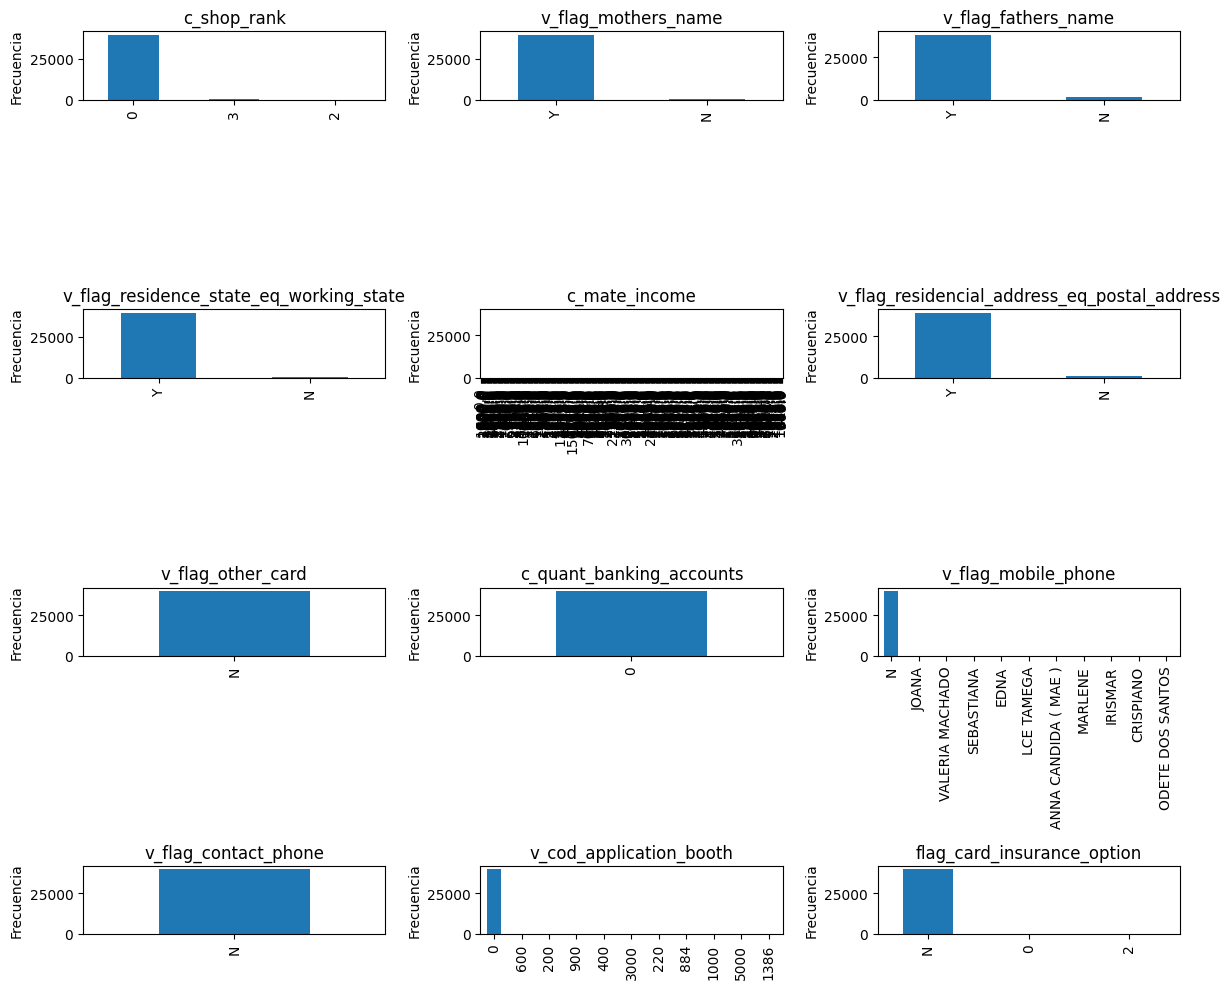

In [25]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 10))


for i, columna in enumerate(v_unit):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    df[columna].value_counts().plot(kind='bar', ax=ax, title=columna)
    ax.set_xlabel(None)
    ax.set_ylabel('Frecuencia')

# Ajustar el diseño y mostrar el gráfico
plt.tight_layout()
plt.show()

Detectamos 12 variables unitarias, procedemos a eliminarlas ya que no aportan informacion sifnificatica

In [26]:
df= df.drop(v_unit, axis = 1)

In [27]:
df

,id_client,id_shop,v_sex,v_marital_status,c_age,v_flag_residencial_phone,v_area_code_residencial_phone,c_payment_day,v_residence_type,c_months_in_residence,v_flag_residence_town_eq_working_town,c_months_in_the_job,v_profession_code,c_personal_net_income,c_quant_additional_cards_in_the_application,v_target_label_bad=1
0,1,22,F,O,44,N,31,12,P,12,N,48,731,300,0,0
1,2,15,F,S,18,Y,31,20,P,216,Y,12,853,300,0,0
2,3,24,F,C,22,Y,31,8,P,48,Y,12,40,229,0,0
3,4,12,F,C,47,N,31,25,P,180,N,24,35,304,0,0
4,5,16,F,S,28,Y,31,25,O,12,Y,12,24,250,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,39996,23,F,S,30,Y,31,20,P,12,N,48,1,727,0,0
39996,39997,25,F,S,58,Y,31,12,P,48,N,120,13,1176,0,0
39997,39998,23,F,C,33,Y,31,1,P,36,Y,36,717,3500,1,0
39998,39999,15,F,C,36,Y,31,12,P,204,Y,24,113,1810,0,0


### 2.4.3 variables categoricas

damos una revision rapida a las variables categoricas

In [28]:
for col in df.filter(like="v_").columns:
    display(categoricas(df,col))
    print("\n")

,v_sex_valores,%_aparicion
0,F,69.6%
1,M,30.4%


,v_marital_status_valores,%_aparicion
0,S,50.94%
1,C,34.3%
2,O,5.57%
3,V,4.89%
4,D,4.3%


,v_flag_residencial_phone_valores,%_aparicion
0,Y,81.62%
1,N,18.38%


,v_area_code_residencial_phone_valores,%_aparicion
0,31,70.19%
1,50,22.25%
2,5,4.86%
3,23,1.94%
4,24,0.25%
5,49,0.1%
6,32,0.07%
7,27,0.07%
8,38,0.03%
9,42,0.03%


,v_residence_type_valores,%_aparicion
0,P,74.39%
1,A,12.77%
2,C,8.73%
3,O,4.11%


,v_flag_residence_town_eq_working_town_valores,%_aparicion
0,N,54.38%
1,Y,45.62%


,v_profession_code_valores,%_aparicion
0,999,12.72%
1,950,9.25%
2,13,4.92%
3,205,4.59%
4,26,3.87%
...,...,...
284,920,0.0%
285,705,0.0%
286,5,0.0%
287,9,0.0%


,v_target_label_bad=1_valores,%_aparicion
0,0,80.18%
1,1,19.79%
2,N,0.03%


para la target detectamos que hay 'N' y solo deberia de haber 0 y 1, asumimos que el valor correcto es 0 ya que en otras columnas 'N' significaba no

In [29]:
df[df['v_target_label_bad=1'] == 'N']

,id_client,id_shop,v_sex,v_marital_status,c_age,v_flag_residencial_phone,v_area_code_residencial_phone,c_payment_day,v_residence_type,c_months_in_residence,v_flag_residence_town_eq_working_town,c_months_in_the_job,v_profession_code,c_personal_net_income,c_quant_additional_cards_in_the_application,v_target_label_bad=1
894,895,22,F,O,56,Y,31,8,P,84,N,360,165,N,0,N
2724,2725,22,F,C,49,Y,31,28,P,12,N,120,131,N,0,N
16162,16163,25,F,S,25,Y,50,12,P,240,Y,36,853,N,0,N
28274,28275,22,F,C,54,Y,31,18,P,384,N,48,13,N,0,N
29343,29344,22,F,C,33,Y,31,3,P,132,N,60,950,N,0,N
30810,30811,4,F,O,61,Y,31,28,P,336,N,72,305,N,0,N
31502,31503,22,F,S,25,N,50,18,P,180,N,0,205,N,0,N
32048,32049,16,F,D,55,Y,31,23,P,108,N,0,131,N,0,N
34467,34468,20,F,V,73,Y,31,18,P,132,N,300,703,N,0,N
35658,35659,22,F,O,62,N,50,8,P,300,N,180,165,N,0,N


In [30]:
df.loc[df['v_target_label_bad=1'] == 'N','v_target_label_bad=1'] = '0'

In [31]:
df['v_target_label_bad=1'] = df['v_target_label_bad=1'].astype('Int64')

In [32]:
df['v_target_label_bad=1'].value_counts()

v_target_label_bad=1
0    32075
1     7912
Name: count, dtype: Int64

ahora vamos a analizar las variables numericas 

### 2.4.4 Variables numericas

**Variable c_age**

In [33]:
df['c_age'].value_counts()

c_age
20    2040
19    2003
21    1815
22    1549
18    1466
      ... 
15       3
86       1
88       1
84       1
95       1
Name: count, Length: 73, dtype: int64

In [34]:
df['c_age'].dtype

dtype('int64')

**variable c_payment_day**

In [35]:
df['c_payment_day'].value_counts()

c_payment_day
12    10203
8      7157
18     6649
20     5014
28     3654
25     2716
3      1552
23     1128
1      1093
11      209
16      208
6       127
22      119
9       106
27       51
15        1
Name: count, dtype: int64

In [36]:
df['c_payment_day'].dtype

dtype('int64')

**variable c_months_in_the_job**

In [37]:
df['c_months_in_the_job'].value_counts()

c_months_in_the_job
12      11596
0        8348
24       4017
36       2925
60       1922
48       1891
72       1391
120      1237
84        767
96        764
180       579
240       534
108       424
144       380
132       356
156       325
168       305
192       286
216       264
300       199
204       183
228       170
360       168
264       152
252       145
276       143
288        97
312        79
324        76
336        65
480        31
420        30
348        27
384        17
408        15
372        13
396        12
432        12
444        10
456         6
468         4
504         3
600         3
516         2
684         2
492         2
552         1
1176        1
588         1
708         1
660         1
1104        1
612         1
852         1
780         1
576         1
Name: count, dtype: int64

In [38]:
df['c_months_in_the_job'].dtype

dtype('int64')

**variable c_months_in_residence**

In [39]:
df['c_months_in_residence'].value_counts()

c_months_in_residence
12     4884
24     2929
120    2756
240    2731
36     2379
       ... 
876       1
912       1
900       1
852       1
780       1
Name: count, Length: 76, dtype: int64

In [40]:
df['c_months_in_residence'].dtype

dtype('int64')

**variable c_personal_net_income**

In [41]:
df['c_personal_net_income'].value_counts()

c_personal_net_income
300     2038
500     1586
400     1582
180     1485
600     1212
        ... 
3285       1
1754       1
3345       1
941        1
3015       1
Name: count, Length: 2328, dtype: int64

In [42]:
df['c_personal_net_income'].dtype

dtype('O')

revisemos porque no es numerica la columna

In [43]:
def es_numerico(cadena):
    try:
        float(cadena)
        return True
    except ValueError:
        return False
df[~df['c_personal_net_income'].apply(es_numerico)]

,id_client,id_shop,v_sex,v_marital_status,c_age,v_flag_residencial_phone,v_area_code_residencial_phone,c_payment_day,v_residence_type,c_months_in_residence,v_flag_residence_town_eq_working_town,c_months_in_the_job,v_profession_code,c_personal_net_income,c_quant_additional_cards_in_the_application,v_target_label_bad=1
894,895,22,F,O,56,Y,31,8,P,84,N,360,165,N,0,0
2724,2725,22,F,C,49,Y,31,28,P,12,N,120,131,N,0,0
16162,16163,25,F,S,25,Y,50,12,P,240,Y,36,853,N,0,0
28274,28275,22,F,C,54,Y,31,18,P,384,N,48,13,N,0,0
29343,29344,22,F,C,33,Y,31,3,P,132,N,60,950,N,0,0
30810,30811,4,F,O,61,Y,31,28,P,336,N,72,305,N,0,0
31502,31503,22,F,S,25,N,50,18,P,180,N,0,205,N,0,0
32048,32049,16,F,D,55,Y,31,23,P,108,N,0,131,N,0,0
34467,34468,20,F,V,73,Y,31,18,P,132,N,300,703,N,0,0
35658,35659,22,F,O,62,N,50,8,P,300,N,180,165,N,0,0


vemos que hay registros 'N', esto lo vamos a dejar como null por el momento

In [44]:
df.loc[~df['c_personal_net_income'].apply(es_numerico), 'c_personal_net_income'] = np.nan

In [45]:
df['c_personal_net_income'] = pd.to_numeric(df['c_personal_net_income'], errors='coerce')
df['c_personal_net_income'].astype('Float64')
df['c_personal_net_income'].value_counts()

c_personal_net_income
300.0     2038
500.0     1586
400.0     1582
180.0     1485
600.0     1212
          ... 
3285.0       1
1754.0       1
3345.0       1
941.0        1
3015.0       1
Name: count, Length: 2327, dtype: int64

In [46]:
df['c_personal_net_income'].dtype

dtype('float64')

**variable c_quant_additional_cards_in_the_application**

In [47]:
df['c_quant_additional_cards_in_the_application'].value_counts()

c_quant_additional_cards_in_the_application
0    34698
1     4574
2      712
3        3
Name: count, dtype: int64

In [48]:
df['c_quant_additional_cards_in_the_application'].dtype

dtype('int64')

## 2.5 consistencia

**variable c_age**

In [49]:
df['c_age'].describe()

count    39987.000000
mean        34.634731
std         13.056103
min         15.000000
25%         23.000000
50%         33.000000
75%         43.000000
max         95.000000
Name: c_age, dtype: float64

el rango de edad es razonable, el minimo de 15 es dudoso pero hay bancos que ofrecen creditos a menores de edad, por lo mirdntras se deja el valor

**variable c_payment_day**

In [50]:
df['c_payment_day'].describe()

count    39987.000000
mean        15.327782
std          7.165887
min          1.000000
25%          9.000000
50%         12.000000
75%         20.000000
max         28.000000
Name: c_payment_day, dtype: float64

**variable c_months_in_the_job**

In [51]:
df['c_months_in_the_job'].describe()

count    39987.000000
mean        50.670868
std         74.244637
min          0.000000
25%         12.000000
50%         24.000000
75%         60.000000
max       1176.000000
Name: c_months_in_the_job, dtype: float64

convirtamoslo a años

In [52]:
tmp = df['c_months_in_the_job']/12
tmp.describe()

count    39987.000000
mean         4.222572
std          6.187053
min          0.000000
25%          1.000000
50%          2.000000
75%          5.000000
max         98.000000
Name: c_months_in_the_job, dtype: float64

parece dudosa el maximo de 98 años trabajando, vamos a comparar los registros con la edad

In [53]:
df[df['c_months_in_the_job']/12 >= df['c_age']]

,id_client,id_shop,v_sex,v_marital_status,c_age,v_flag_residencial_phone,v_area_code_residencial_phone,c_payment_day,v_residence_type,c_months_in_residence,v_flag_residence_town_eq_working_town,c_months_in_the_job,v_profession_code,c_personal_net_income,c_quant_additional_cards_in_the_application,v_target_label_bad=1
3322,3323,11,M,S,22,Y,31,28,A,24,Y,780,855,226.0,0,0
5464,5465,25,F,S,23,Y,31,18,P,276,Y,276,213,230.0,0,0
5983,5984,4,F,S,18,Y,31,8,P,12,Y,852,653,280.0,0,0
6100,6101,66,F,S,51,Y,31,8,P,120,N,612,131,500.0,0,0
9963,9964,6,M,S,21,Y,24,3,P,24,Y,360,717,900.0,0,0
10640,10641,14,F,S,53,Y,5,25,P,24,N,1104,863,1.0,0,0
14985,14986,5,M,C,32,Y,5,20,P,120,Y,432,26,360.0,0,0
15770,15771,24,F,C,43,Y,31,28,P,252,N,600,166,800.0,0,0
15860,15861,55,F,S,57,Y,31,18,C,96,N,684,131,800.0,0,0
17498,17499,20,F,S,22,Y,31,12,P,48,Y,324,70,600.0,0,1


para estos registros vamos a dejar en Null a la variable c_months_in_the_job

In [54]:
df.loc[df['c_months_in_the_job']/12 >= df['c_age'],'c_months_in_the_job'] = np.nan
df['c_months_in_the_job'] = df['c_months_in_the_job'].astype('Int32')

In [55]:
df['c_months_in_the_job'].describe()

count      39964.0
mean     50.422881
std      73.264669
min            0.0
25%           12.0
50%           24.0
75%           60.0
max          708.0
Name: c_months_in_the_job, dtype: Float64

**variable c_months_in_residence**

In [56]:
df['c_months_in_residence'].describe()

count    39987.000000
mean       153.401155
std        136.411786
min          0.000000
25%         36.000000
50%        120.000000
75%        240.000000
max       1188.000000
Name: c_months_in_residence, dtype: float64

In [57]:
tmp = df['c_months_in_residence']/12
tmp.describe()

count    39987.000000
mean        12.783430
std         11.367649
min          0.000000
25%          3.000000
50%         10.000000
75%         20.000000
max         99.000000
Name: c_months_in_residence, dtype: float64

In [58]:
df[df['c_months_in_residence']/12 > df['c_age']]

,id_client,id_shop,v_sex,v_marital_status,c_age,v_flag_residencial_phone,v_area_code_residencial_phone,c_payment_day,v_residence_type,c_months_in_residence,v_flag_residence_town_eq_working_town,c_months_in_the_job,v_profession_code,c_personal_net_income,c_quant_additional_cards_in_the_application,v_target_label_bad=1
36,37,25,M,S,18,Y,31,23,P,228,N,0,950,800.0,0,1
52,53,6,F,O,17,Y,34,12,P,216,Y,24,62,200.0,0,1
211,212,2,M,S,20,Y,31,28,C,252,Y,0,213,239.0,0,0
250,251,22,F,C,38,Y,31,12,P,480,Y,0,999,180.0,0,0
269,270,17,M,S,18,N,50,8,C,228,N,12,514,152.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39660,39661,55,M,S,18,Y,50,18,P,228,Y,0,264,360.0,0,0
39683,39684,55,F,S,20,Y,31,8,P,252,N,24,950,200.0,0,1
39720,39721,24,F,S,24,Y,50,18,C,300,Y,12,853,250.0,0,0
39763,39764,25,F,S,45,N,31,12,P,552,N,0,123,300.0,0,0


hacemos lo mismo 

In [59]:
df.loc[df['c_months_in_residence']/12 > df['c_age'],'c_months_in_residence'] = np.nan
df['c_months_in_residence'] = df['c_months_in_residence'].astype('Int32')

In [60]:
df['c_months_in_residence'].describe()

count       39142.0
mean     149.241837
std      133.729237
min             0.0
25%            36.0
50%           120.0
75%           240.0
max           912.0
Name: c_months_in_residence, dtype: Float64

**variable c_personal_net_income**

In [61]:
df['c_personal_net_income'].describe()

count    3.997500e+04
mean     9.204901e+03
std      4.730953e+05
min      0.000000e+00
25%      2.700000e+02
50%      4.000000e+02
75%      7.420000e+02
max      3.852910e+07
Name: c_personal_net_income, dtype: float64

In [62]:
df['v_area_code_residencial_phone'] = df['v_area_code_residencial_phone'].astype('str')

## 2.6 Normalización

### v_marital_status

In [63]:
df['v_marital_status'].value_counts(1)

v_marital_status
S    0.509441
C    0.342986
O    0.055668
V    0.048916
D    0.042989
Name: proportion, dtype: float64

vemos que para la variable  v_marital_status_valores el mayor porcentaje del se concentra entre soltor@ y casad@s, vamos a juntar la categoria divorciad@ y viud@ con otros, para no tener categorias con poco porcentaje

In [64]:
df.loc[df['v_marital_status'].isin(['D','V']),'v_marital_status'] = 'O'

In [65]:
df['v_marital_status'].value_counts(1)

v_marital_status
S    0.509441
C    0.342986
O    0.147573
Name: proportion, dtype: float64

### v_area_code_residencial_phone

In [66]:
df['v_area_code_residencial_phone'].value_counts(1)

v_area_code_residencial_phone
31    0.701878
50    0.222497
5     0.048641
23    0.019431
24    0.002451
49    0.001025
32    0.000675
27    0.000650
38    0.000275
42    0.000250
52    0.000250
56    0.000225
68    0.000125
33    0.000100
11    0.000075
41    0.000075
43    0.000075
8     0.000075
26    0.000075
9     0.000050
48    0.000050
12    0.000050
7     0.000050
1     0.000050
34    0.000050
25    0.000025
61    0.000025
10    0.000025
58    0.000025
13    0.000025
3     0.000025
40    0.000025
19    0.000025
20    0.000025
67    0.000025
30    0.000025
35    0.000025
28    0.000025
60    0.000025
69    0.000025
39    0.000025
36    0.000025
37    0.000025
62    0.000025
29    0.000025
15    0.000025
46    0.000025
44    0.000025
45    0.000025
18    0.000025
6     0.000025
17    0.000025
2     0.000025
14    0.000025
54    0.000025
22    0.000025
59    0.000025
53    0.000025
21    0.000025
Name: proportion, dtype: float64

para la variable v_area_code_residencial_phone el mayor porcentaje de los datos se encuentra en los codigos 31 y 50, vamos a juntar los otros codigos con una categoria 'otros'

In [67]:
df['v_area_code_residencial_phone'] = df['v_area_code_residencial_phone'].astype('O')


In [69]:
df['v_area_code_residencial_phone'].isin(['31','50'])

0        True
1        True
2        True
3        True
4        True
         ... 
39995    True
39996    True
39997    True
39998    True
39999    True
Name: v_area_code_residencial_phone, Length: 39987, dtype: bool

In [ ]:
df.loc[~df['v_area_code_residencial_phone'].isin([31,50]),'v_area_code_residencial_phone'] = 'Otros'

In [68]:
df['v_area_code_residencial_phone'].value_counts(1)


v_area_code_residencial_phone
Otros    1.0
Name: proportion, dtype: float64

### v_profession_code

In [69]:
df['v_profession_code'].value_counts(1)


v_profession_code
999    0.127216
950    0.092455
13     0.049216
205    0.045890
26     0.038738
         ...   
920    0.000025
705    0.000025
5      0.000025
9      0.000025
152    0.000025
Name: proportion, Length: 289, dtype: float64

In [70]:
np.sort(df['v_profession_code'].unique())

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  15,  16,  17,  18,  19,  21,  22,  24,  25,  26,  28,  29,
        30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
        43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  55,  56,
        57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
        70,  71,  72,  73,  76,  77,  78,  79,  80,  88,  89,  99, 100,
       102, 103, 105, 106, 107, 108, 109, 110, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 123, 124, 125, 127, 129, 130, 131, 132, 133,
       134, 135, 136, 137, 138, 139, 140, 141, 150, 151, 152, 153, 154,
       155, 158, 159, 161, 163, 164, 165, 166, 167, 168, 169, 201, 202,
       203, 205, 209, 210, 211, 213, 214, 215, 217, 218, 219, 220, 221,
       222, 223, 250, 251, 253, 254, 255, 260, 261, 262, 263, 264, 265,
       266, 300, 301, 302, 304, 305, 307, 308, 309, 310, 311, 312, 350,
       351, 352, 400, 401, 402, 403, 450, 453, 500, 501, 502, 50

No sabemos el significado de cada codigo por lo que no podemos usar alguna logica para normalizar el codigo de profesion, la unica opcion es dividir en intervalos 
* 0-200
* 201 - 400
* 401 - 600 
* 601 - 800 
* 801 - 999

In [71]:
df['v_profession_code'] = df['v_profession_code'].astype('O')
def categorizar_valor(valor):
    try:
        val = int(valor)
    except ValueError:
        return valor
    if valor <= 200:
        return '0-200'
    elif valor <= 400:
        return '201-400'
    elif valor <= 600:
        return '401-600'
    elif valor <= 800:
        return '601-800'
    else:
        return '801-999'
df['v_profession_code'] = df['v_profession_code'].apply(categorizar_valor)


In [72]:
df['v_profession_code'].value_counts(1)

v_profession_code
0-200      0.359842
801-999    0.303073
601-800    0.156976
201-400    0.112687
401-600    0.067422
Name: proportion, dtype: float64

vamos a hacer una ultima revision de Null una vez que terminamos de modificar las variables


In [73]:
df.isnull().mean(axis=0)

id_client                                      0.000000
id_shop                                        0.000000
v_sex                                          0.000025
v_marital_status                               0.000000
c_age                                          0.000000
v_flag_residencial_phone                       0.000000
v_area_code_residencial_phone                  0.000000
c_payment_day                                  0.000000
v_residence_type                               0.000000
c_months_in_residence                          0.021132
v_flag_residence_town_eq_working_town          0.000000
c_months_in_the_job                            0.000575
v_profession_code                              0.000000
c_personal_net_income                          0.000300
c_quant_additional_cards_in_the_application    0.000000
v_target_label_bad=1                           0.000000
dtype: float64

# 3. Análisis Exploratorio de Datos

In [74]:
palette = sns.color_palette("pastel")

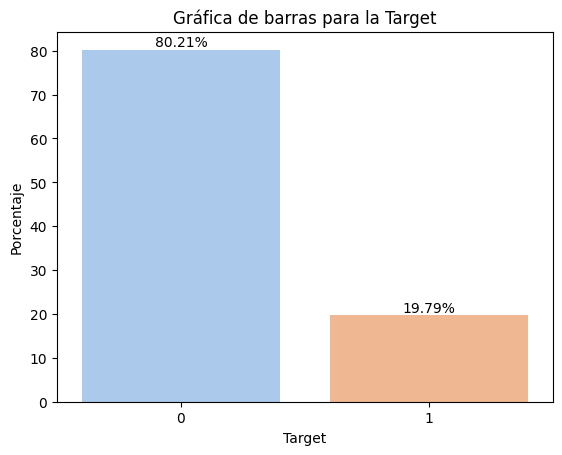

In [75]:
prop = df['v_target_label_bad=1'].value_counts(normalize=True) * 100

ax = sns.barplot(x=prop.index, y=prop.values, palette = palette)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')


plt.xlabel('Target')
plt.ylabel('Porcentaje')
plt.title('Gráfica de barras para la Target')

# Mostrar la gráfica
plt.show()

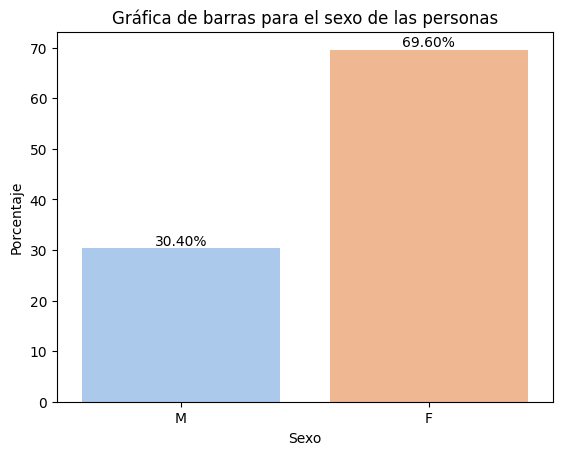

In [76]:
prop = df['v_sex'].value_counts(normalize=True) * 100

ax = sns.barplot(x=prop.index, y=prop.values, palette = palette, order = ['M','F'])
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')


plt.xlabel('Sexo')
plt.ylabel('Porcentaje')
plt.title('Gráfica de barras para el sexo de las personas')

# Mostrar la gráfica
plt.show()

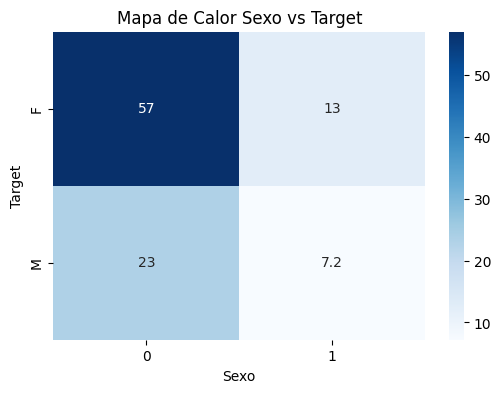

In [77]:
crosstab = pd.crosstab(df['v_sex'], df['v_target_label_bad=1'], normalize='all') * 100

plt.figure(figsize=(6, 4))
sns.heatmap(crosstab, annot=True, cmap= 'Blues', cbar=True )
plt.xlabel('Sexo')
plt.ylabel('Target')

plt.title('Mapa de Calor Sexo vs Target')
plt.show()

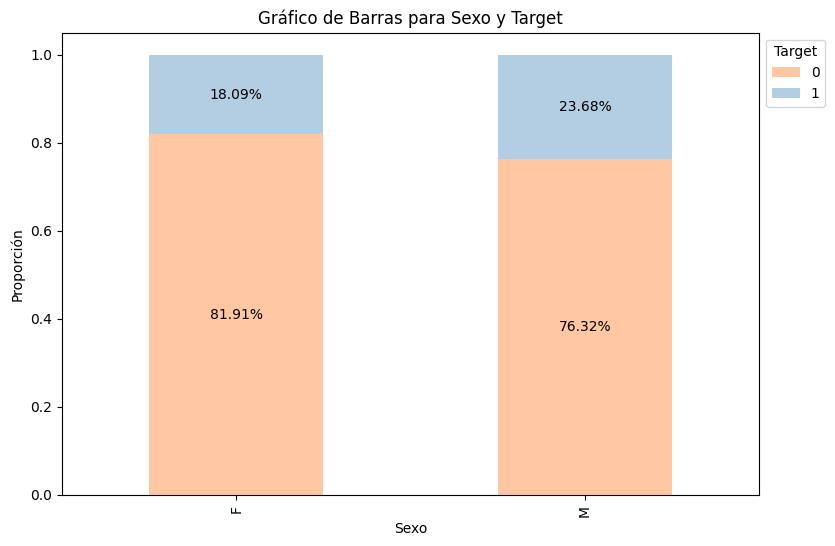

In [78]:
cross = pd.crosstab(df['v_sex'], df['v_target_label_bad=1'], normalize='index')

colores = ['#ffc8a2', '#b3cde3', '#ccebc5', '#decbe4', '#fed9a6', '#ffffcc', '#e5d8bd', '#fddaec', '#f2f2f2']

ax = cross.plot(kind='bar', stacked=True, figsize=(9, 6), color = colores)

plt.xlabel('Sexo')
plt.ylabel('Proporción')
plt.title('Gráfico de Barras para Sexo y Target')
ax.legend(title='Target', loc='upper left', bbox_to_anchor=(1, 1))
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.2%}', (x + width/2, y + height/2), ha='center', va='center', fontsize=10, color='black')

plt.show()

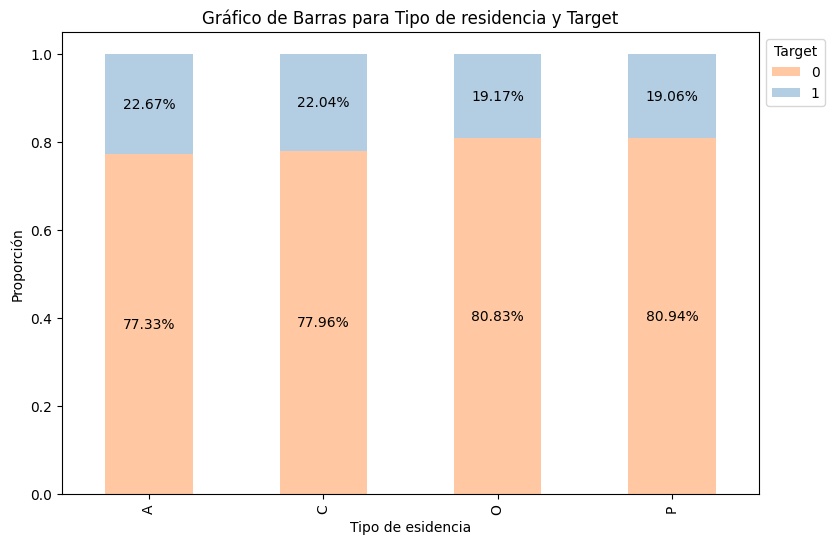

In [79]:


cross = pd.crosstab(df['v_residence_type'], df['v_target_label_bad=1'], normalize='index')

colores = ['#ffc8a2', '#b3cde3', '#ccebc5', '#decbe4', '#fed9a6', '#ffffcc', '#e5d8bd', '#fddaec', '#f2f2f2']

ax = cross.plot(kind='bar', stacked=True, figsize=(9, 6), color = colores)

plt.xlabel('Tipo de esidencia')
plt.ylabel('Proporción')
plt.title('Gráfico de Barras para Tipo de residencia y Target')
ax.legend(title='Target', loc='upper left', bbox_to_anchor=(1, 1))
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.2%}', (x + width/2, y + height/2), ha='center', va='center', fontsize=10, color='black')

plt.show()

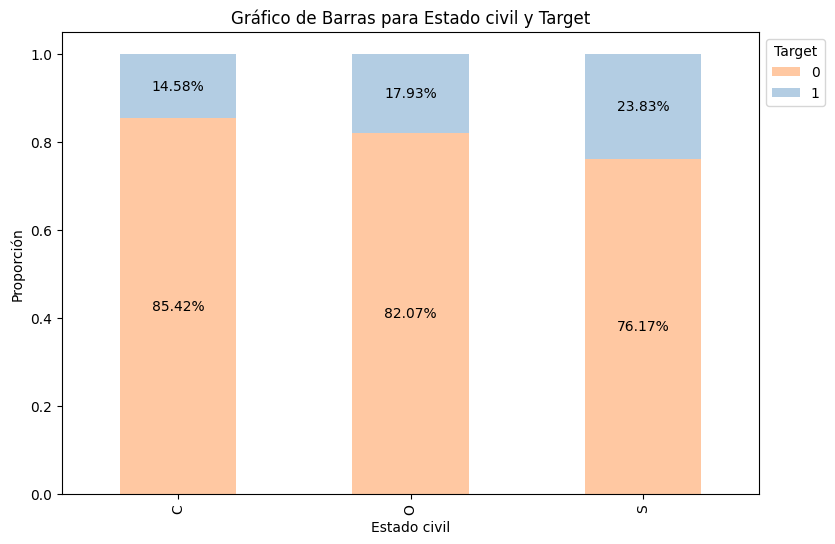

In [80]:
cross = pd.crosstab(df['v_marital_status'], df['v_target_label_bad=1'], normalize='index')

colores = ['#ffc8a2', '#b3cde3', '#ccebc5', '#decbe4', '#fed9a6', '#ffffcc', '#e5d8bd', '#fddaec', '#f2f2f2']

ax = cross.plot(kind='bar', stacked=True, figsize=(9, 6), color = colores)

plt.xlabel('Estado civil')
plt.ylabel('Proporción')
plt.title('Gráfico de Barras para Estado civil y Target')
ax.legend(title='Target', loc='upper left', bbox_to_anchor=(1, 1))
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.2%}', (x + width/2, y + height/2), ha='center', va='center', fontsize=10, color='black')

plt.show()

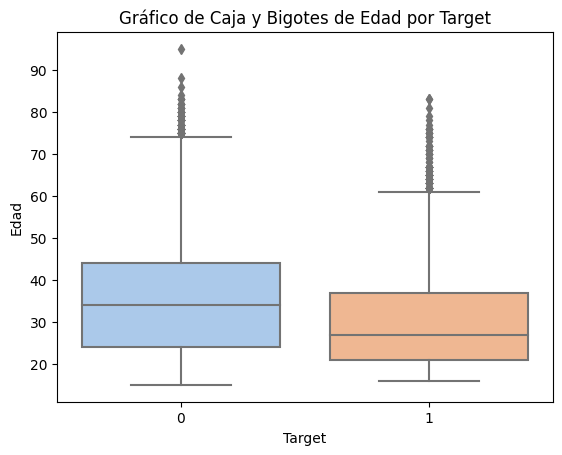

In [81]:
sns.boxplot(x='v_target_label_bad=1', y='c_age', data=df,palette=palette)

plt.xlabel('Target')
plt.ylabel('Edad')
plt.title('Gráfico de Caja y Bigotes de Edad por Target')

plt.show()

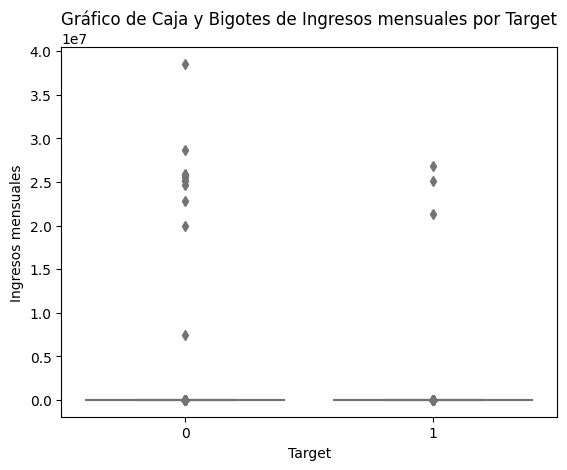

In [82]:
sns.boxplot(x='v_target_label_bad=1', y='c_personal_net_income', data=df,palette=palette)

plt.xlabel('Target')
plt.ylabel('Ingresos mensuales')
plt.title('Gráfico de Caja y Bigotes de Ingresos mensuales por Target')

plt.show()

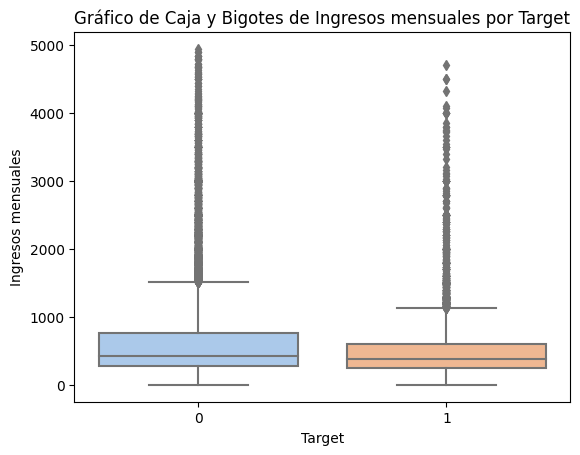

In [83]:
sns.boxplot(x='v_target_label_bad=1', y='c_personal_net_income', data=df.loc[df['c_personal_net_income'] < 5000],palette=palette)

plt.xlabel('Target')
plt.ylabel('Ingresos mensuales')
plt.title('Gráfico de Caja y Bigotes de Ingresos mensuales por Target')

plt.show()

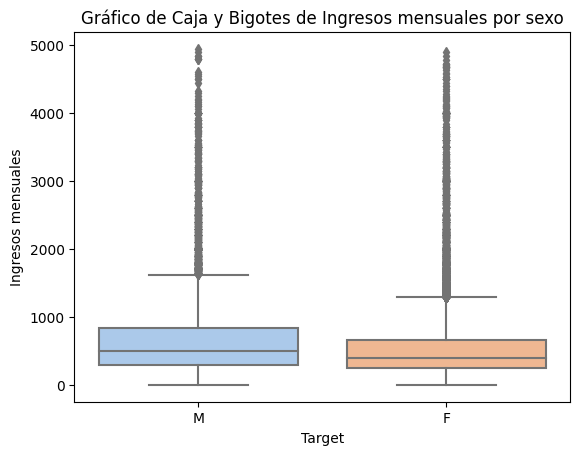

In [84]:
sns.boxplot(x='v_sex', y='c_personal_net_income', data=df.loc[df['c_personal_net_income'] < 5000],palette=palette, order = ['M','F'])

plt.xlabel('Target')
plt.ylabel('Ingresos mensuales')
plt.title('Gráfico de Caja y Bigotes de Ingresos mensuales por sexo')

plt.show()

In [85]:
df.loc[df['c_personal_net_income'] < 5000000].groupby('v_sex')['c_personal_net_income'].mean()

v_sex
F    586.893367
M    716.835641
Name: c_personal_net_income, dtype: float64

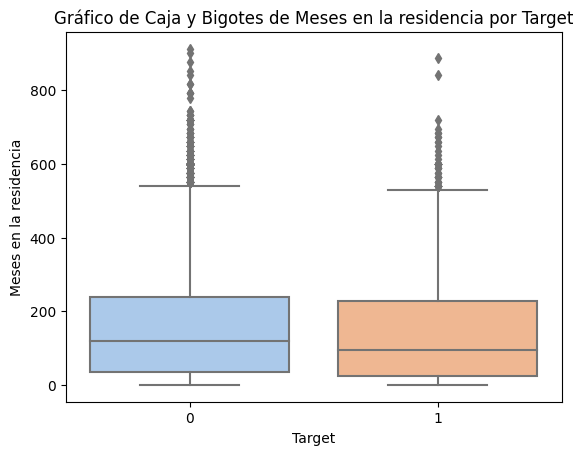

In [86]:
sns.boxplot(x='v_target_label_bad=1', y='c_months_in_residence', data=df,palette=palette)

plt.xlabel('Target')
plt.ylabel('Meses en la residencia')
plt.title('Gráfico de Caja y Bigotes de Meses en la residencia por Target')

plt.show()

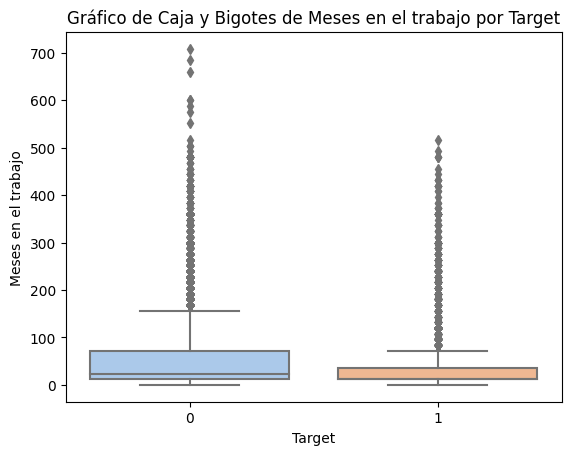

In [87]:
sns.boxplot(x='v_target_label_bad=1', y='c_months_in_the_job', data=df,palette=palette)

plt.xlabel('Target')
plt.ylabel('Meses en el trabajo')
plt.title('Gráfico de Caja y Bigotes de Meses en el trabajo por Target')

plt.show()

In [88]:
df.groupby('v_target_label_bad=1')[['c_personal_net_income','c_age','c_months_in_residence','c_months_in_the_job']].mean()

,c_personal_net_income,c_age,c_months_in_residence,c_months_in_the_job
v_target_label_bad=1,,,,
0,9058.892672,35.712019,152.650453,53.964623
1,9796.593105,30.267442,135.293873,36.068277


/tmp/ipykernel_89187/3394861250.py:1: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(x='c_age', y='c_personal_net_income', data=df, hue='v_target_label_bad=1', palette=palette)


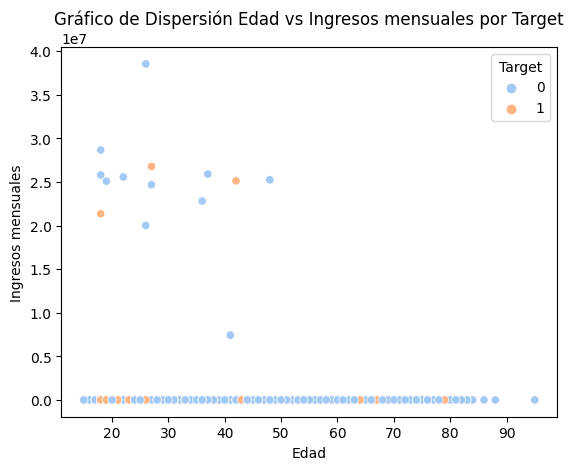

In [89]:
sns.scatterplot(x='c_age', y='c_personal_net_income', data=df, hue='v_target_label_bad=1', palette=palette)

plt.xlabel('Edad')
plt.ylabel('Ingresos mensuales')
plt.title('Gráfico de Dispersión Edad vs Ingresos mensuales por Target')
plt.legend(title='Target')

plt.show()



/tmp/ipykernel_89187/2004712267.py:1: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(x='c_age', y='c_personal_net_income', data=df.loc[df['c_personal_net_income'] < 5000000], hue='v_target_label_bad=1', palette=palette)


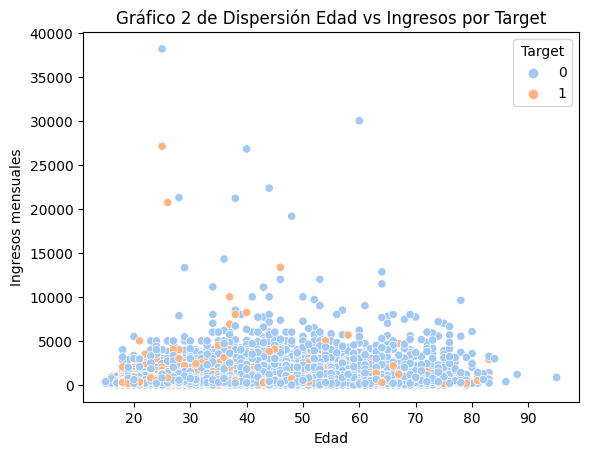

In [90]:
sns.scatterplot(x='c_age', y='c_personal_net_income', data=df.loc[df['c_personal_net_income'] < 5000000], hue='v_target_label_bad=1', palette=palette)
plt.xlabel('Edad')
plt.ylabel('Ingresos mensuales')
plt.title('Gráfico 2 de Dispersión Edad vs Ingresos por Target')

plt.legend(title='Target')

plt.show()

/tmp/ipykernel_89187/1013933163.py:1: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(x='c_months_in_the_job', y='c_personal_net_income', data=df, hue='v_target_label_bad=1', palette=palette)


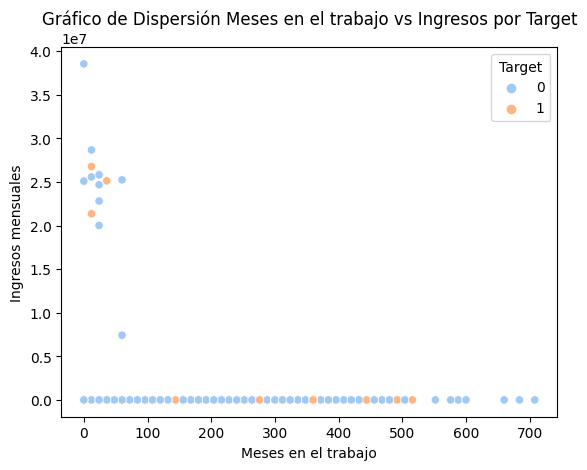

In [91]:
sns.scatterplot(x='c_months_in_the_job', y='c_personal_net_income', data=df, hue='v_target_label_bad=1', palette=palette)

plt.xlabel('Meses en el trabajo')
plt.ylabel('Ingresos mensuales')
plt.title('Gráfico de Dispersión Meses en el trabajo vs Ingresos por Target')

plt.legend(title='Target')

plt.show()


/tmp/ipykernel_89187/2988787324.py:1: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(x='c_months_in_the_job', y='c_personal_net_income', data=df.loc[df['c_personal_net_income'] < 5000000], hue='v_target_label_bad=1', palette=palette)


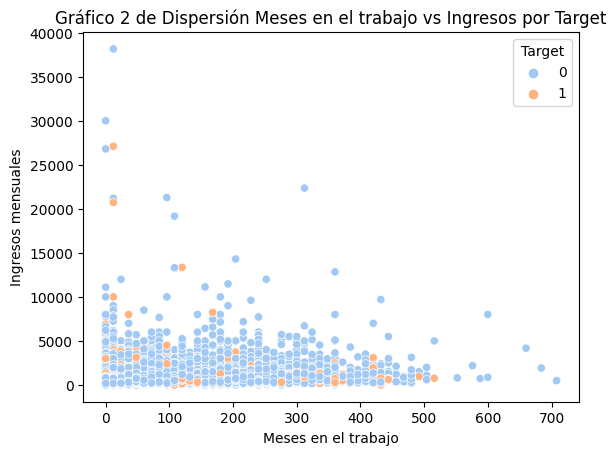

In [92]:
sns.scatterplot(x='c_months_in_the_job', y='c_personal_net_income', data=df.loc[df['c_personal_net_income'] < 5000000], hue='v_target_label_bad=1', palette=palette)

plt.xlabel('Meses en el trabajo')
plt.ylabel('Ingresos mensuales')
plt.title('Gráfico 2 de Dispersión Meses en el trabajo vs Ingresos por Target')

plt.legend(title='Target')

plt.show()

/tmp/ipykernel_89187/3033129540.py:1: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(y='c_months_in_the_job', x='c_age', data=df, hue='v_target_label_bad=1', palette=palette)


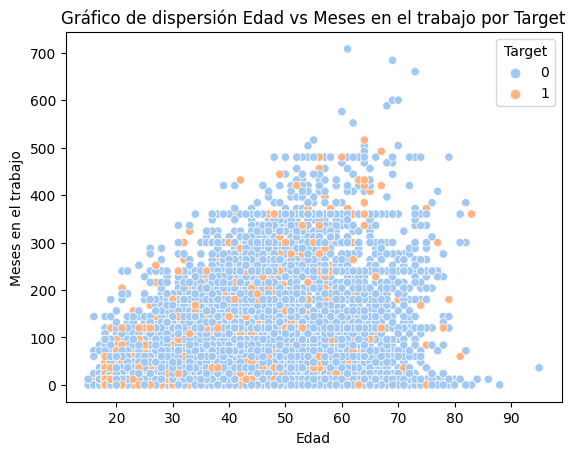

In [93]:
sns.scatterplot(y='c_months_in_the_job', x='c_age', data=df, hue='v_target_label_bad=1', palette=palette)

plt.xlabel('Edad')
plt.ylabel('Meses en el trabajo')
plt.title('Gráfico de dispersión Edad vs Meses en el trabajo por Target')

plt.legend(title='Target')

plt.show()


# 5. Datos anomalos

/tmp/ipykernel_89187/1667822470.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x='c_age',bins = 15, palette = palette)


Text(0.5, 1.0, 'Histograma de Edad')

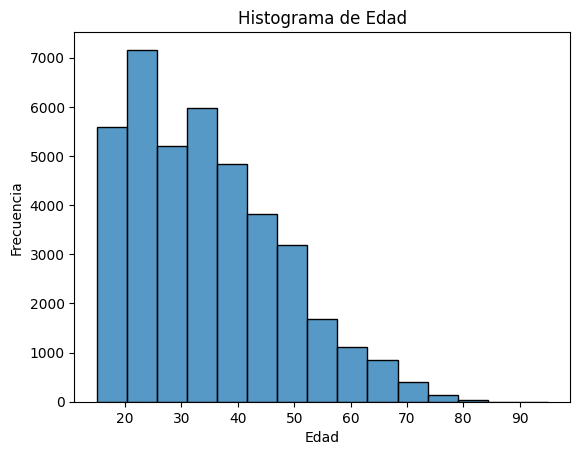

In [94]:
sns.histplot(data=df, x='c_age',bins = 15, palette = palette)

plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.title('Histograma de Edad')

/tmp/ipykernel_89187/1493040616.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x='c_payment_day',bins = 15, palette = palette)


Text(0.5, 1.0, 'Histograma de Día de pago')

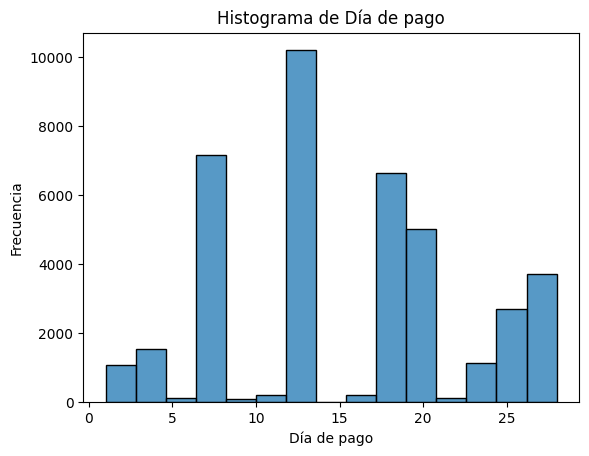

In [95]:
sns.histplot(data=df, x='c_payment_day',bins = 15, palette = palette)

plt.xlabel('Día de pago')
plt.ylabel('Frecuencia')
plt.title('Histograma de Día de pago')

/tmp/ipykernel_89187/310972946.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=tmp , bins=15, palette = palette)


Text(0.5, 1.0, 'Histograma de Meses en residencia')

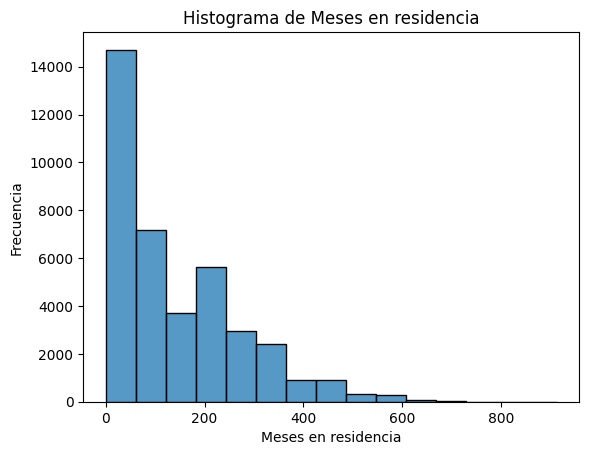

In [96]:
tmp = df.loc[~df['c_months_in_residence'].isna(),'c_months_in_residence']
tmp = tmp.astype('int64')
sns.histplot(x=tmp , bins=15, palette = palette)

plt.xlabel('Meses en residencia')
plt.ylabel('Frecuencia')
plt.title('Histograma de Meses en residencia')

/tmp/ipykernel_89187/3150608055.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x= tmp,bins = 15, palette = palette)


Text(0.5, 1.0, 'Histograma de Meses en el trabajo')

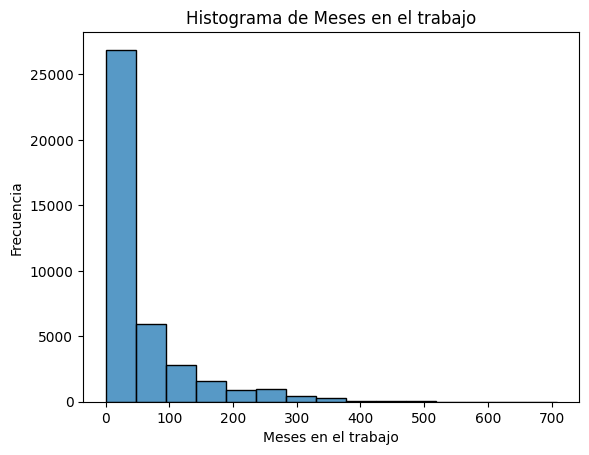

In [97]:
tmp = df.loc[~df['c_months_in_the_job'].isna(),'c_months_in_the_job']
tmp = tmp.astype('int64')
sns.histplot(x= tmp,bins = 15, palette = palette)

plt.xlabel('Meses en el trabajo')
plt.ylabel('Frecuencia')
plt.title('Histograma de Meses en el trabajo')

/tmp/ipykernel_89187/826967387.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x='c_personal_net_income',bins = 15, palette = palette)


Text(0.5, 1.0, 'Histograma de Ingreso mensual')

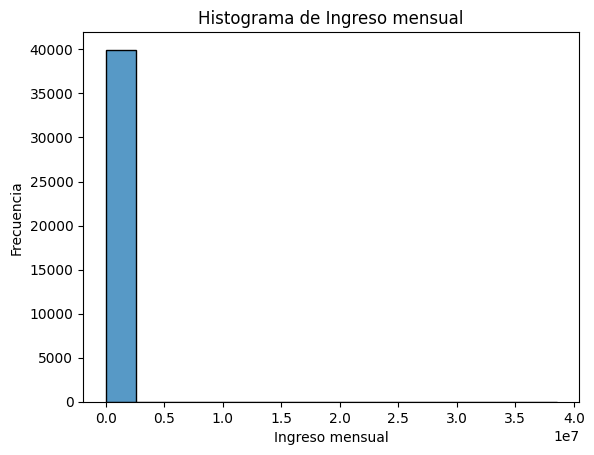

In [98]:
sns.histplot(data=df, x='c_personal_net_income',bins = 15, palette = palette)

plt.xlabel('Ingreso mensual')
plt.ylabel('Frecuencia')
plt.title('Histograma de Ingreso mensual')

/tmp/ipykernel_89187/54532132.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x='c_quant_additional_cards_in_the_application',bins = 15, palette = palette)


Text(0.5, 1.0, 'Histograma de cantidad de tarjetas adicionales solicitadas en el mismo formulario de solicitud')

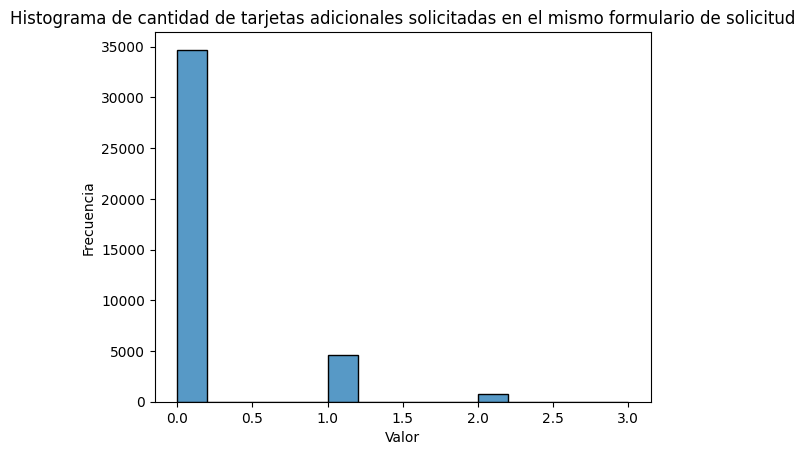

In [99]:
sns.histplot(data=df, x='c_quant_additional_cards_in_the_application',bins = 15, palette = palette)

plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.title('Histograma de cantidad de tarjetas adicionales solicitadas en el mismo formulario de solicitud')

In [100]:
def aux_outliers(a,b,c):
    a=set(a)
    b=set(b)
    c=set(c)
    a_=a.intersection(b)

    b_=b.intersection(c)

    c_=a.intersection(c)

    outliers_index=list(set(list(a_)+list(b_)+list(c_)))
    return outliers_index
def OUTLIERS(df,cols):
    results=pd.DataFrame()
    data_iqr=df.copy()
    data_per=df.copy()
    total=[]
    total_per=[]
    total_z=[]
    indices_=[]

    for col in cols:
        #IQR
        Q1=df[col].quantile(0.25)
        Q3=df[col].quantile(0.75)
        IQR=Q3-Q1
        INF=Q1-1.5*(IQR)
        SUP=Q3+1.5*(IQR)
    
        
        n_outliers=df[(df[col] < INF) | (df[col] > SUP)].shape[0]
        total.append(n_outliers)
        indices_iqr=list(df[(df[col] < INF) | (df[col] > SUP)].index)        
        #Percentiles
        INF_pe=np.percentile(df[col].dropna(),5)
    
        SUP_pe=np.percentile(df[col].dropna(),95)
        n_outliers_per=df[(df[col] < INF_pe) | (df[col] > SUP_pe)].shape[0]
        total_per.append(n_outliers_per)
        indices_per=list(df[(df[col] < INF_pe) | (df[col] > SUP_pe)].index)
        
        #MEAN CHANGE
        
        perc_100 = [x / 100 for x in range(100)]
        dist = df[col].describe(perc_100).iloc[4:]
        change_dist = df[col].describe(perc_100).iloc[4:].diff()
        mean_change = df[col].describe(
            perc_100).iloc[4:].diff().mean()
        if change_dist["max"] > mean_change:
            ub = dist["max"] - mean_change
            if ub < dist["99%"]:
                ub = dist["99%"]
        else:
            ub = dist["max"]

        if change_dist["1%"] > mean_change:
            lb = dist["0%"] + mean_change
            if lb > dist["1%"]:
                lb = dist["1%"]
        else:
            lb = dist["0%"]
        n_total_z=df[(df[col] < lb) | (df[col] > ub)].shape[0]
        total_z.append(n_total_z)
        indices_z=list(df[(df[col] < lb) | (df[col] > ub)].index)
        
        indices_.append(aux_outliers(indices_iqr,indices_per,indices_z))
        
    results["features"]=cols
    results["n_outliers_IQR"]=total
    results["n_outliers_Percentil"]=total_per
    results["n_outliers_Mean_Change"]=total_z
    results["n_outliers_IQR_%"]=round((results["n_outliers_IQR"]/df.shape[0])*100,2)
    results["n_outliers_Percentil_%"]=round((results["n_outliers_Percentil"]/df.shape[0])*100,2)
    results["n_outliers_Mean_Change_%"]=round((results["n_outliers_Mean_Change"]/df.shape[0])*100,2)
    results["indices"]=indices_
    results["total_outliers"]=results["indices"].map(lambda x:len(x))
    results["%_outliers"]=results["indices"].map(lambda x:round(((len(x)/df.shape[0])*100),2))
    results=results[['features', 'n_outliers_IQR', 'n_outliers_Percentil',
       'n_outliers_Mean_Change', 'n_outliers_IQR_%', 'n_outliers_Percentil_%',
       'n_outliers_Mean_Change_%',  'total_outliers', '%_outliers','indices']]
    return results


In [101]:
outliers=OUTLIERS(df,['c_personal_net_income','c_months_in_the_job','c_months_in_residence','c_age'])

In [102]:
df

,id_client,id_shop,v_sex,v_marital_status,c_age,v_flag_residencial_phone,v_area_code_residencial_phone,c_payment_day,v_residence_type,c_months_in_residence,v_flag_residence_town_eq_working_town,c_months_in_the_job,v_profession_code,c_personal_net_income,c_quant_additional_cards_in_the_application,v_target_label_bad=1
0,1,22,F,O,44,N,Otros,12,P,12,N,48,601-800,300.0,0,0
1,2,15,F,S,18,Y,Otros,20,P,216,Y,12,801-999,300.0,0,0
2,3,24,F,C,22,Y,Otros,8,P,48,Y,12,0-200,229.0,0,0
3,4,12,F,C,47,N,Otros,25,P,180,N,24,0-200,304.0,0,0
4,5,16,F,S,28,Y,Otros,25,O,12,Y,12,0-200,250.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,39996,23,F,S,30,Y,Otros,20,P,12,N,48,0-200,727.0,0,0
39996,39997,25,F,S,58,Y,Otros,12,P,48,N,120,0-200,1176.0,0,0
39997,39998,23,F,C,33,Y,Otros,1,P,36,Y,36,601-800,3500.0,1,0
39998,39999,15,F,C,36,Y,Otros,12,P,204,Y,24,0-200,1810.0,0,0


In [103]:
from  functools import reduce
indices=list(outliers["indices"].values)
indices=list(set(reduce(lambda x,y: x+y, indices)))
len(indices)

4004

In [104]:
len(indices)/df.shape[0]

0.10013254307649987

In [105]:
df[df.index.isin(indices)]

,id_client,id_shop,v_sex,v_marital_status,c_age,v_flag_residencial_phone,v_area_code_residencial_phone,c_payment_day,v_residence_type,c_months_in_residence,v_flag_residence_town_eq_working_town,c_months_in_the_job,v_profession_code,c_personal_net_income,c_quant_additional_cards_in_the_application,v_target_label_bad=1
13,14,24,M,C,36,Y,Otros,12,P,120,Y,36,0-200,1987.0,1,0
23,24,21,F,S,46,Y,Otros,8,A,48,Y,192,801-999,3100.0,0,0
44,45,11,M,O,26,N,Otros,12,P,120,Y,0,801-999,2701.0,0,0
45,46,23,F,S,66,Y,Otros,12,P,48,Y,288,801-999,365.0,0,0
49,50,24,F,C,43,Y,Otros,18,A,96,N,240,401-600,350.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39977,39978,4,F,S,64,Y,Otros,28,P,252,N,360,0-200,280.0,0,1
39987,39988,25,F,C,44,Y,Otros,8,P,180,N,240,0-200,400.0,0,0
39991,39992,1,F,S,63,Y,Otros,12,P,264,N,180,0-200,3015.0,1,0
39997,39998,23,F,C,33,Y,Otros,1,P,36,Y,36,601-800,3500.0,1,0


In [106]:
df=df[~df.index.isin(indices)].reset_index(drop=True)

/tmp/ipykernel_89187/1667822470.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x='c_age',bins = 15, palette = palette)


Text(0.5, 1.0, 'Histograma de Edad')

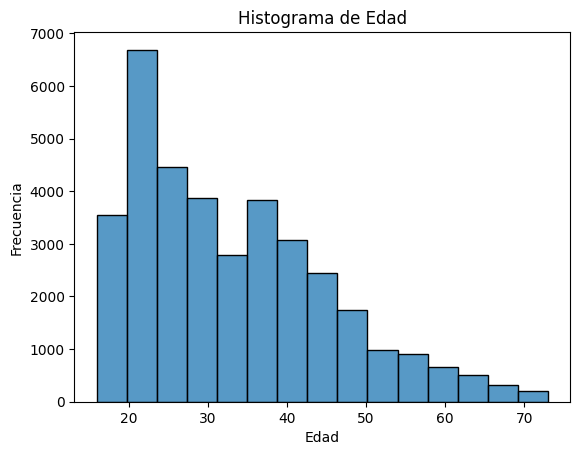

In [107]:
sns.histplot(data=df, x='c_age',bins = 15, palette = palette)

plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.title('Histograma de Edad')

/tmp/ipykernel_89187/1666745990.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=tmp , bins=15, palette = palette)


Text(0.5, 1.0, 'Histograma de Meses en recidencia')

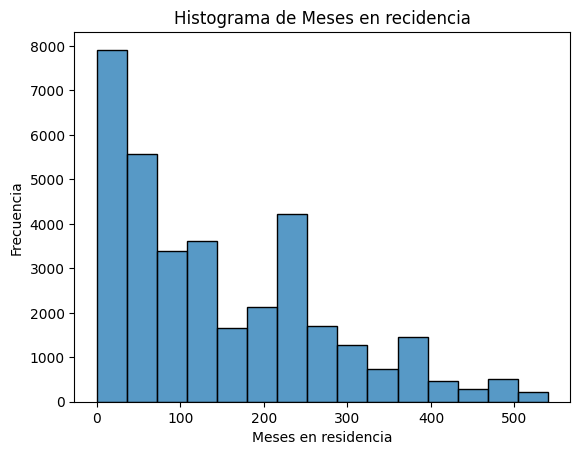

In [108]:
tmp = df.loc[~df['c_months_in_residence'].isna(),'c_months_in_residence']
tmp = tmp.astype('int64')
sns.histplot(x=tmp , bins=15, palette = palette)

plt.xlabel('Meses en residencia')
plt.ylabel('Frecuencia')
plt.title('Histograma de Meses en recidencia')

/tmp/ipykernel_89187/3150608055.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x= tmp,bins = 15, palette = palette)


Text(0.5, 1.0, 'Histograma de Meses en el trabajo')

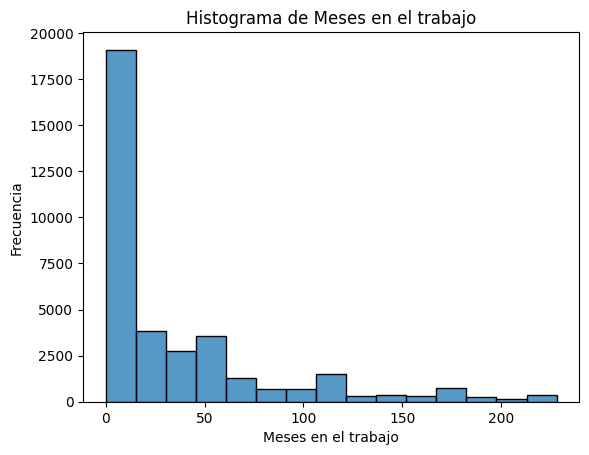

In [109]:
tmp = df.loc[~df['c_months_in_the_job'].isna(),'c_months_in_the_job']
tmp = tmp.astype('int64')
sns.histplot(x= tmp,bins = 15, palette = palette)

plt.xlabel('Meses en el trabajo')
plt.ylabel('Frecuencia')
plt.title('Histograma de Meses en el trabajo')

/tmp/ipykernel_89187/826967387.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x='c_personal_net_income',bins = 15, palette = palette)


Text(0.5, 1.0, 'Histograma de Ingreso mensual')

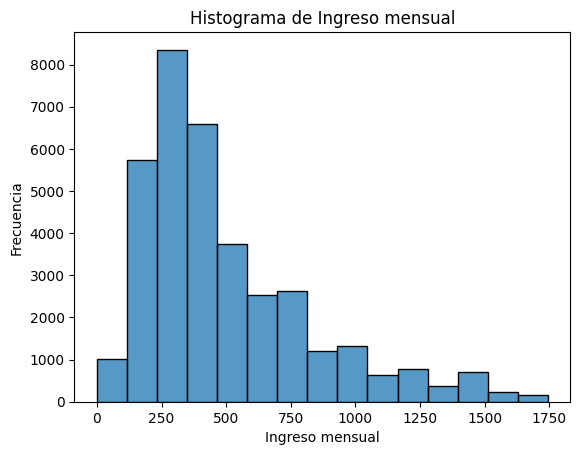

In [110]:
sns.histplot(data=df, x='c_personal_net_income',bins = 15, palette = palette)

plt.xlabel('Ingreso mensual')
plt.ylabel('Frecuencia')
plt.title('Histograma de Ingreso mensual')

# 6. Datos faltantes

## 6.1 conjunto de entrenamiento y test estatrificado


In [111]:
from sklearn.model_selection import train_test_split
y = df['v_target_label_bad=1']
X_train,X_test=train_test_split(df,test_size=.3,stratify=y,random_state=13)

## 6.2 Imputación

In [112]:
X_train.isnull().sum()

id_client                                        0
id_shop                                          0
v_sex                                            1
v_marital_status                                 0
c_age                                            0
v_flag_residencial_phone                         0
v_area_code_residencial_phone                    0
c_payment_day                                    0
v_residence_type                                 0
c_months_in_residence                          573
v_flag_residence_town_eq_working_town            0
c_months_in_the_job                             20
v_profession_code                                0
c_personal_net_income                            3
c_quant_additional_cards_in_the_application      0
v_target_label_bad=1                             0
dtype: int64

In [113]:
X_test.isnull().sum()

id_client                                        0
id_shop                                          0
v_sex                                            0
v_marital_status                                 0
c_age                                            0
v_flag_residencial_phone                         0
v_area_code_residencial_phone                    0
c_payment_day                                    0
v_residence_type                                 0
c_months_in_residence                          241
v_flag_residence_town_eq_working_town            0
c_months_in_the_job                              2
v_profession_code                                0
c_personal_net_income                            5
c_quant_additional_cards_in_the_application      0
v_target_label_bad=1                             0
dtype: int64

In [114]:
X_train.isnull().mean()

id_client                                      0.000000
id_shop                                        0.000000
v_sex                                          0.000040
v_marital_status                               0.000000
c_age                                          0.000000
v_flag_residencial_phone                       0.000000
v_area_code_residencial_phone                  0.000000
c_payment_day                                  0.000000
v_residence_type                               0.000000
c_months_in_residence                          0.022749
v_flag_residence_town_eq_working_town          0.000000
c_months_in_the_job                            0.000794
v_profession_code                              0.000000
c_personal_net_income                          0.000119
c_quant_additional_cards_in_the_application    0.000000
v_target_label_bad=1                           0.000000
dtype: float64

In [115]:
X_test.isnull().mean()

id_client                                      0.000000
id_shop                                        0.000000
v_sex                                          0.000000
v_marital_status                               0.000000
c_age                                          0.000000
v_flag_residencial_phone                       0.000000
v_area_code_residencial_phone                  0.000000
c_payment_day                                  0.000000
v_residence_type                               0.000000
c_months_in_residence                          0.022325
v_flag_residence_town_eq_working_town          0.000000
c_months_in_the_job                            0.000185
v_profession_code                              0.000000
c_personal_net_income                          0.000463
c_quant_additional_cards_in_the_application    0.000000
v_target_label_bad=1                           0.000000
dtype: float64

In [116]:
from scipy import stats
mean=int(X_train["c_months_in_residence"].dropna().mean())
median=X_train["c_months_in_residence"].dropna().median()
mode=X_train["c_months_in_residence"].dropna().mode()

originales=list(X_train["c_months_in_residence"].dropna().values)
imputados=list(X_train["c_months_in_residence"].fillna(mean).values)
print('ks mean: ', stats.ks_2samp(originales,imputados))
originales=list(X_train["c_months_in_residence"].dropna().values)
imputados=list(X_train["c_months_in_residence"].fillna(median).values)
print('ks median: ', stats.ks_2samp(originales,imputados))
originales=list(X_train["c_months_in_residence"].dropna().values)
imputados=list(X_train["c_months_in_residence"].fillna(mode[0]).values)
print('ks mode: ', stats.ks_2samp(originales,imputados))


ks mean:  KstestResult(statistic=0.013315724375487337, pvalue=0.02398197054668784, statistic_location=132, statistic_sign=1)
ks median:  KstestResult(statistic=0.011346276246381015, pvalue=0.08047287107244716, statistic_location=108, statistic_sign=1)
ks mode:  KstestResult(statistic=0.019375635864248425, pvalue=0.00017209331936937451, statistic_location=12, statistic_sign=-1)


para c_months_in_residence el mejor p_value es el de la mediana


In [117]:
mean=int(X_train["c_months_in_the_job"].dropna().mean())
median=X_train["c_months_in_the_job"].dropna().median()
mode=X_train["c_months_in_the_job"].dropna().mode()

originales=list(X_train["c_months_in_the_job"].dropna().values)
imputados=list(X_train["c_months_in_the_job"].fillna(mean).values)
print('ks mean: ', stats.ks_2samp(originales,imputados))
originales=list(X_train["c_months_in_the_job"].dropna().values)
imputados=list(X_train["c_months_in_the_job"].fillna(median).values)
print('ks median: ', stats.ks_2samp(originales,imputados))
originales=list(X_train["c_months_in_the_job"].dropna().values)
imputados=list(X_train["c_months_in_the_job"].fillna(mode[0]).values)
print('ks mode: ', stats.ks_2samp(originales,imputados))


ks mean:  KstestResult(statistic=0.0005681054692489029, pvalue=1.0, statistic_location=36, statistic_sign=1)
ks median:  KstestResult(statistic=0.00037287935475383005, pvalue=1.0, statistic_location=12, statistic_sign=-1)
ks mode:  KstestResult(statistic=0.00037287935475383005, pvalue=1.0, statistic_location=12, statistic_sign=-1)


para c_months_in_the_job se puede usar cualquier metodo de imputacion ya que el pvalue es de 1

In [118]:
mean=X_train["c_personal_net_income"].dropna().mean()
median=X_train["c_personal_net_income"].dropna().median()
mode=X_train["c_personal_net_income"].dropna().mode()

originales=list(X_train["c_personal_net_income"].dropna().values)
imputados=list(X_train["c_personal_net_income"].fillna(mean).values)
print('ks mean: ', stats.ks_2samp(originales,imputados))
originales=list(X_train["c_personal_net_income"].dropna().values)
imputados=list(X_train["c_personal_net_income"].fillna(median).values)
print('ks median: ', stats.ks_2samp(originales,imputados))
originales=list(X_train["c_personal_net_income"].dropna().values)
imputados=list(X_train["c_personal_net_income"].fillna(mode[0]).values)
print('ks mode: ', stats.ks_2samp(originales,imputados))

ks mean:  KstestResult(statistic=7.370896055225451e-05, pvalue=1.0, statistic_location=496.0, statistic_sign=1)
ks median:  KstestResult(statistic=5.9256594105050464e-05, pvalue=1.0, statistic_location=399.0, statistic_sign=1)
ks mode:  KstestResult(statistic=7.530742254813205e-05, pvalue=1.0, statistic_location=300.0, statistic_sign=-1)


para c_personal_net_income se puede usar cualquier metodo de imputacion ya que el pvalue es de 1 

In [119]:
from sklearn.impute import SimpleImputer

imp=SimpleImputer(missing_values=np.nan,strategy="most_frequent")
imp2=SimpleImputer(missing_values=np.nan,strategy="mean")
imp3=SimpleImputer(missing_values=np.nan,strategy="median")
imp.fit(X_train[['v_sex']])
imp2.fit(X_train[['c_personal_net_income']])
imp3.fit(X_train[['c_months_in_residence','c_months_in_the_job']])

SimpleImputer(strategy='median')

In [120]:
imp3.statistics_

array([120.,  12.])

In [121]:
X_train[["v_sex"]]=imp.transform(X_train[["v_sex"]])
X_test[["v_sex"]]=imp.transform(X_test[["v_sex"]])
X_train[['c_personal_net_income']]=imp2.transform(X_train[['c_personal_net_income']])
X_test[['c_personal_net_income']] =imp2.transform(X_test[['c_personal_net_income']])
X_train[['c_months_in_residence','c_months_in_the_job']]=imp3.transform(X_train[['c_months_in_residence','c_months_in_the_job']])
X_test[['c_months_in_residence','c_months_in_the_job']]=imp3.transform(X_test[['c_months_in_residence','c_months_in_the_job']])

In [122]:
X_train.isnull().sum()

id_client                                      0
id_shop                                        0
v_sex                                          0
v_marital_status                               0
c_age                                          0
v_flag_residencial_phone                       0
v_area_code_residencial_phone                  0
c_payment_day                                  0
v_residence_type                               0
c_months_in_residence                          0
v_flag_residence_town_eq_working_town          0
c_months_in_the_job                            0
v_profession_code                              0
c_personal_net_income                          0
c_quant_additional_cards_in_the_application    0
v_target_label_bad=1                           0
dtype: int64

In [123]:
X_test.isnull().sum()

id_client                                      0
id_shop                                        0
v_sex                                          0
v_marital_status                               0
c_age                                          0
v_flag_residencial_phone                       0
v_area_code_residencial_phone                  0
c_payment_day                                  0
v_residence_type                               0
c_months_in_residence                          0
v_flag_residence_town_eq_working_town          0
c_months_in_the_job                            0
v_profession_code                              0
c_personal_net_income                          0
c_quant_additional_cards_in_the_application    0
v_target_label_bad=1                           0
dtype: int64

# 7. Ingenieria de Variables

## 7.1 Categoricas

### 7.1.1 Ordinales

no se detectaron variables vategoricas ordinales

### 7.1.2 Nominales

In [124]:
from sklearn.preprocessing import OneHotEncoder

one=OneHotEncoder(drop="first")
one.fit(X_train[['v_sex','v_marital_status','v_flag_residencial_phone','v_area_code_residencial_phone','v_residence_type',
            'v_flag_residence_town_eq_working_town','v_profession_code']])

OneHotEncoder(drop='first')

In [125]:
one.get_feature_names_out()

array(['v_sex_M', 'v_marital_status_O', 'v_marital_status_S',
       'v_flag_residencial_phone_Y', 'v_residence_type_C',
       'v_residence_type_O', 'v_residence_type_P',
       'v_flag_residence_town_eq_working_town_Y',
       'v_profession_code_201-400', 'v_profession_code_401-600',
       'v_profession_code_601-800', 'v_profession_code_801-999'],
      dtype=object)

In [126]:
columns  =  one.get_feature_names_out()

onehot=pd.DataFrame(one.transform(X_train[['v_sex','v_marital_status','v_flag_residencial_phone','v_area_code_residencial_phone','v_residence_type',
            'v_flag_residence_town_eq_working_town','v_profession_code']]).toarray(),columns=columns)

In [127]:
X_train.reset_index(drop=True, inplace=True)
onehot
X_train = pd.concat([X_train,
           onehot],axis=1).drop(columns=['v_sex','v_marital_status','v_flag_residencial_phone','v_area_code_residencial_phone','v_residence_type',
            'v_flag_residence_town_eq_working_town','v_profession_code'])

In [128]:
columns  =  one.get_feature_names_out()

onehot=pd.DataFrame(one.transform(X_test[['v_sex','v_marital_status','v_flag_residencial_phone','v_area_code_residencial_phone','v_residence_type',
            'v_flag_residence_town_eq_working_town','v_profession_code']]).toarray(),columns=columns)
X_test.reset_index(drop=True, inplace=True)
onehot
X_test = pd.concat([X_test,
           onehot],axis=1).drop(columns=['v_sex','v_marital_status','v_flag_residencial_phone','v_area_code_residencial_phone','v_residence_type',
            'v_flag_residence_town_eq_working_town','v_profession_code'])

creamos una variable para la diferencia entre años de trabajo y edad


In [129]:
X_train['c_dif_age_job'] = X_train['c_age'] - X_train['c_months_in_the_job']/12

In [130]:
X_test['c_dif_age_job'] = X_test['c_age'] - X_test['c_months_in_the_job']/12

creamos una variable para la diferencia entre años de residencia y edad

In [131]:
X_train['c_dif_age_res'] = X_train['c_age'] - X_train['c_months_in_residence']/12

In [132]:
X_test['c_dif_age_res'] = X_test['c_age'] - X_train['c_months_in_residence']/12

creamos una variable para el ingreso total en el ultimo trabajo

In [133]:
X_train['c_income_tot_job'] = X_train['c_months_in_the_job']*X_train['c_personal_net_income']
X_test['c_income_tot_job'] = X_test['c_months_in_the_job']*X_test['c_personal_net_income']

creamos una variable que mida la razon entre el ingreso y la edad

In [134]:
X_train['c_rat_income_age'] = X_train['c_personal_net_income'] / X_train['c_age']
X_test['c_rat_income_age'] = X_test['c_personal_net_income'] / X_test['c_age']

In [135]:
X_train

,id_client,id_shop,c_age,c_payment_day,c_months_in_residence,c_months_in_the_job,c_personal_net_income,c_quant_additional_cards_in_the_application,v_target_label_bad=1,v_sex_M,v_marital_status_O,v_marital_status_S,v_flag_residencial_phone_Y,v_residence_type_C,v_residence_type_O,v_residence_type_P,v_flag_residence_town_eq_working_town_Y,v_profession_code_201-400,v_profession_code_401-600,v_profession_code_601-800,v_profession_code_801-999,c_dif_age_job,c_dif_age_res,c_income_tot_job,c_rat_income_age
0,14033,22,19,12,192.0,12.0,550.0,0,0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,18.0,3.0,6600.0,28.947368
1,29653,11,50,20,132.0,12.0,226.0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,49.0,39.0,2712.0,4.520000
2,13740,55,46,12,48.0,108.0,374.0,0,0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,37.0,42.0,40392.0,8.130435
3,4743,14,20,12,204.0,12.0,250.0,0,1,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,19.0,3.0,3000.0,12.500000
4,37362,20,29,18,132.0,108.0,280.0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,20.0,18.0,30240.0,9.655172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25183,25484,25,22,18,180.0,36.0,300.0,0,0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,19.0,7.0,10800.0,13.636364
25184,7069,12,27,12,120.0,0.0,400.0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,27.0,17.0,0.0,14.814815
25185,36218,24,38,1,204.0,12.0,55.0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,37.0,21.0,660.0,1.447368
25186,21693,55,23,25,240.0,0.0,400.0,0,1,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,23.0,3.0,0.0,17.391304


por ultimo escalamos los datos

In [1]:
from sklearn.preprocessing import MinMaxScaler
columns = X_train.columns
esc = MinMaxScaler()
esc.fit(X_train)

X_train = pd.DataFrame(esc.transform(X_train), columns= columns)
X_test = pd.DataFrame(esc.transform(X_test), columns= columns)

NameError: name 'X_train' is not defined

# 8. Datos finales


In [137]:
X_train

,id_client,id_shop,c_age,c_payment_day,c_months_in_residence,c_months_in_the_job,c_personal_net_income,c_quant_additional_cards_in_the_application,v_target_label_bad=1,v_sex_M,v_marital_status_O,v_marital_status_S,v_flag_residencial_phone_Y,v_residence_type_C,v_residence_type_O,v_residence_type_P,v_flag_residence_town_eq_working_town_Y,v_profession_code_201-400,v_profession_code_401-600,v_profession_code_601-800,v_profession_code_801-999,c_dif_age_job,c_dif_age_res,c_income_tot_job,c_rat_income_age
0,0.350786,0.221053,0.052632,0.407407,0.355556,0.052632,0.315367,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.202899,0.041667,0.017048,0.327186
1,0.741355,0.105263,0.596491,0.703704,0.244444,0.052632,0.129587,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.652174,0.541667,0.007005,0.051089
2,0.343460,0.568421,0.526316,0.407407,0.088889,0.473684,0.214450,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.478261,0.583333,0.104333,0.091897
3,0.118496,0.136842,0.070175,0.407407,0.377778,0.052632,0.143349,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.217391,0.041667,0.007749,0.141285
4,0.934113,0.200000,0.228070,0.629630,0.244444,0.473684,0.160550,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.231884,0.250000,0.078110,0.109130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25183,0.637111,0.252632,0.105263,0.629630,0.333333,0.157895,0.172018,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.217391,0.097222,0.027897,0.154129
25184,0.176656,0.115789,0.192982,0.407407,0.222222,0.000000,0.229358,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.236111,0.000000,0.167449
25185,0.905508,0.242105,0.385965,0.000000,0.377778,0.052632,0.031537,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.478261,0.291667,0.001705,0.016359
25186,0.542320,0.568421,0.122807,0.888889,0.444444,0.000000,0.229358,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.275362,0.041667,0.000000,0.196570


In [138]:
X_test

,id_client,id_shop,c_age,c_payment_day,c_months_in_residence,c_months_in_the_job,c_personal_net_income,c_quant_additional_cards_in_the_application,v_target_label_bad=1,v_sex_M,v_marital_status_O,v_marital_status_S,v_flag_residencial_phone_Y,v_residence_type_C,v_residence_type_O,v_residence_type_P,v_flag_residence_town_eq_working_town_Y,v_profession_code_201-400,v_profession_code_401-600,v_profession_code_601-800,v_profession_code_801-999,c_dif_age_job,c_dif_age_res,c_income_tot_job,c_rat_income_age
0,0.659040,0.568421,0.403509,0.629630,0.200000,0.105263,0.395642,0.000000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.478261,0.319444,0.042775,0.199973
1,0.841397,0.252632,0.070175,0.629630,0.066667,0.052632,0.123853,0.000000,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.217391,0.125000,0.006695,0.122070
2,0.545020,0.178947,0.210526,0.703704,0.088889,0.052632,0.141628,0.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.333333,0.333333,0.007656,0.099707
3,0.883730,0.021053,0.035088,0.962963,0.333333,0.000000,0.126147,0.000000,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.202899,0.013889,0.000000,0.138145
4,0.960368,0.136842,0.228070,1.000000,0.022222,0.052632,0.114679,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.347826,0.250000,0.006199,0.077950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10790,0.243443,0.252632,0.368421,1.000000,0.222222,0.105263,0.172018,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.449275,0.500000,0.018598,0.091644
10791,0.302103,0.094737,0.368421,0.814815,0.088889,0.157895,0.447248,0.333333,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.434783,0.500000,0.072531,0.238275
10792,0.763259,0.684211,0.210526,0.259259,0.622222,0.105263,0.160550,0.000000,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.318841,0.250000,0.017358,0.113028
10793,0.848098,0.168421,0.473684,0.629630,0.200000,0.052632,0.114679,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.550725,0.402778,0.006199,0.052571


In [139]:
X_train.dtypes

id_client                                      float64
id_shop                                        float64
c_age                                          float64
c_payment_day                                  float64
c_months_in_residence                          float64
c_months_in_the_job                            float64
c_personal_net_income                          float64
c_quant_additional_cards_in_the_application    float64
v_target_label_bad=1                           float64
v_sex_M                                        float64
v_marital_status_O                             float64
v_marital_status_S                             float64
v_flag_residencial_phone_Y                     float64
v_residence_type_C                             float64
v_residence_type_O                             float64
v_residence_type_P                             float64
v_flag_residence_town_eq_working_town_Y        float64
v_profession_code_201-400                      float64
v_professi